# Sperm Morphology Classification

## Project Overview
This notebook implements a deep learning approach for classifying sperm morphology images into three categories:
- **Normal_Sperm**: Healthy sperm cells
- **Abnormal_Sperm**: Abnormal sperm morphology
- **Non-Sperm**: Background or non-sperm objects

### Model Architecture
- **Base Model**: VGG11 (modified for grayscale input)
- **Input Size**: 112x112 grayscale images
- **Number of Classes**: 3

### Dataset
The SMIDS (Sperm Morphology Image Dataset) contains labeled sperm morphology images for training and evaluation.

## 1. Import Required Libraries
Import all necessary Python libraries for data processing, visualization, and deep learning.

In [ ]:
# Import necessary libraries

# Basic data manipulation and numerical operations
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import random
import os

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt  
import matplotlib.image as mpimg

# Image processing and deep learning
from PIL import Image
import torch
import timm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision import transforms
from torchvision import models

# Machine learning utilities
from sklearn.model_selection import train_test_split  
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import auc

## 2. Data Loading and Exploration

### 2.1 Load Dataset Directory Structure
Explore the dataset directory to identify the available classes.

In [43]:
# Dataset path
path = "C:\\Users\\User\\Documents\\GitHub\\Sperm-Morphology Classification\\sperm morphology dataset\\SMIDS"

# List all class directories
classes = os.listdir(path)
print(classes)

['Abnormal_Sperm', 'Non-Sperm', 'Normal_Sperm']


### 2.2 Create DataFrame from Image Files
Create a pandas DataFrame containing file paths and corresponding labels for all images in the dataset.

In [44]:
def make_df(classes, base_dir):
    """
    Create a DataFrame from image files in class directories.
    
    Args:
        classes: List of class names (folder names)
        base_dir: Base directory path containing class folders
    
    Returns:
        DataFrame with columns: file_path, label
    """
    data = []
    for label in classes:
        folder_path = os.path.join(base_dir, label)
        for file in os.listdir(folder_path):
            if file.endswith(('jpg', 'png', 'bmp')):  
                file_path = os.path.join(folder_path, file)
                data.append((file_path, label))
    
    df = pd.DataFrame(data, columns=['file_path', 'label'])
    return df

# Create the dataset DataFrame
df = make_df(classes, path)
print("Shape of dataset is:", df.shape)

Shape of dataset is: (3000, 2)


### 2.3 Check Class Distribution
Examine the distribution of images across different classes to identify any class imbalance.

In [45]:
# Display class distribution
df['label'].value_counts()

label
Normal_Sperm      1021
Abnormal_Sperm    1005
Non-Sperm          974
Name: count, dtype: int64

## 3. Data Visualization

### 3.1 Class Distribution Visualization
Visualize the class distribution using bar charts and pie charts to better understand the dataset balance.

Data analysis for train is in process...



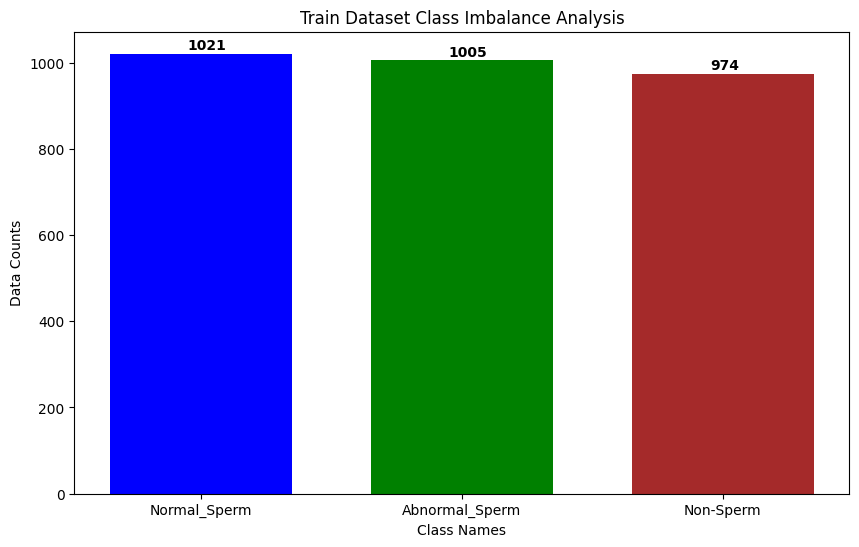

Generating pie chart for Sperm Morphology...



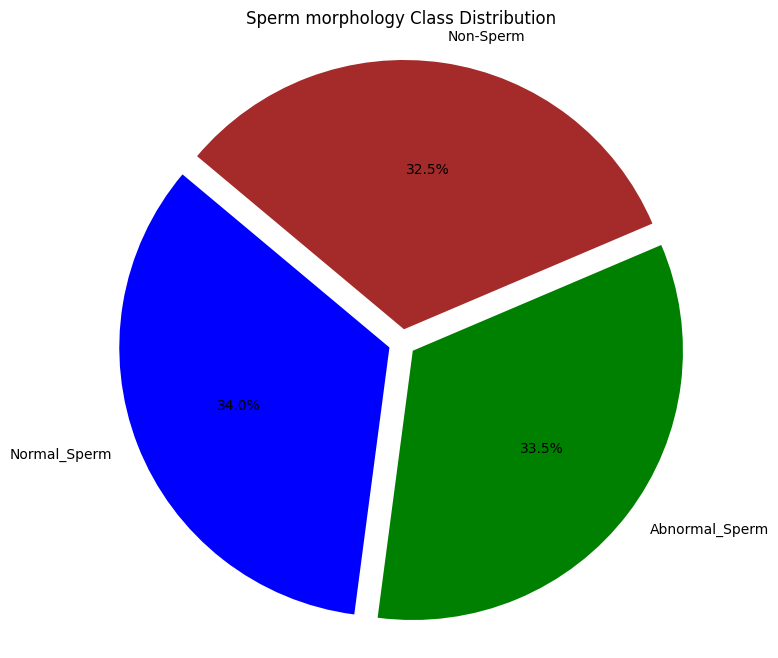

In [46]:
import numpy as np
import matplotlib.pyplot as plt

class Visualization:
    def __init__(self, vis_datas, n_ims, rows, cmap=None, cls_names=None, cls_counts=None, colors=None, t_type="rgb", class_colors=None):
        self.n_ims, self.rows = n_ims, rows
        self.t_type, self.cmap = t_type, cmap
        self.cls_names = cls_names
        self.class_colors = class_colors  # Added: store class specific colors

        data_names = ["train", "val", "test"]
        self.vis_datas = {data_names[i]: vis_datas[i] for i in range(min(len(vis_datas), len(data_names)))}

        if isinstance(cls_counts, list):
            self.analysis_datas = {data_names[i]: cls_counts[i] for i in range(min(len(cls_counts), len(data_names)))}
        else:
            self.analysis_datas = {"all": cls_counts}

        default_colors = ["darkorange", "seagreen", "royalblue"]
        if colors is None:
            self.colors = {data_names[i]: default_colors[i] for i in range(len(self.vis_datas))}
        else:
            self.colors = {data_names[i]: colors[i] for i in range(len(self.vis_datas))}

    def data_analysis(self, cls_counts, save_name):
        print(f"Data analysis for {save_name} is in process...\n")
        width, text_width, text_height = 0.7, 0.05, 2
        cls_names = list(cls_counts.keys())
        counts = list(cls_counts.values())
        
        # Modified: Determine colors based on class_colors mapping
        if self.class_colors:
            bar_colors = [self.class_colors.get(name, 'blue') for name in cls_names]
        else:
            bar_colors = self.colors.get(save_name, "darkorange")

        fig, ax = plt.subplots(figsize=(10, 6))
        indices = np.arange(len(counts))

        ax.bar(indices, counts, width, color=bar_colors)
        ax.set_xlabel("Class Names", color="black")
        ax.set_xticks(indices)
        ax.set_xticklabels(cls_names)
        ax.set_ylabel("Data Counts", color="black")
        ax.set_title(f"{save_name.capitalize()} Dataset Class Imbalance Analysis")
        
        # Calculate dynamic text offset based on max count
        offset = max(counts) * 0.01
        for i, v in enumerate(counts):
            ax.text(i - text_width, v + offset, str(v), color="black", fontweight='bold')
        plt.show()

    def plot_pie_chart(self, cls_counts, save_name="Dataset"):
        print(f"Generating pie chart for {save_name}...\n")
        labels = list(cls_counts.keys())
        sizes = list(cls_counts.values())
        explode = [0.05] * len(labels)

        # Modified: Determine colors based on class_colors mapping
        if self.class_colors:
            pie_colors = [self.class_colors.get(name, 'blue') for name in labels]
        else:
            color = self.colors.get(save_name, None)
            pie_colors = [color] * len(labels) if color else plt.cm.tab20.colors

        plt.figure(figsize=(8, 8))
        plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140, colors=pie_colors)
        plt.title(f"{save_name.capitalize()} Class Distribution")
        plt.axis("equal")
        plt.show()

# --- Execution ---

counts = {
    'Normal_Sperm': 1021, 
    'Abnormal_Sperm': 1005, 
    'Non-Sperm': 974
}

# Define custom colors
class_colors = {
    'Normal_Sperm': 'blue',
    'Abnormal_Sperm': 'green',
    'Non-Sperm': 'brown'
}

vis = Visualization(vis_datas=[[]], n_ims=0, rows=0, cls_counts=counts, class_colors=class_colors)

# Generate Bar Chart
vis.data_analysis(counts, save_name="train")

# Generate Pie Chart
vis.plot_pie_chart(counts, save_name="Sperm Morphology")

### 3.2 Sample Images from Each Class
Display random sample images from each class to visualize the dataset.

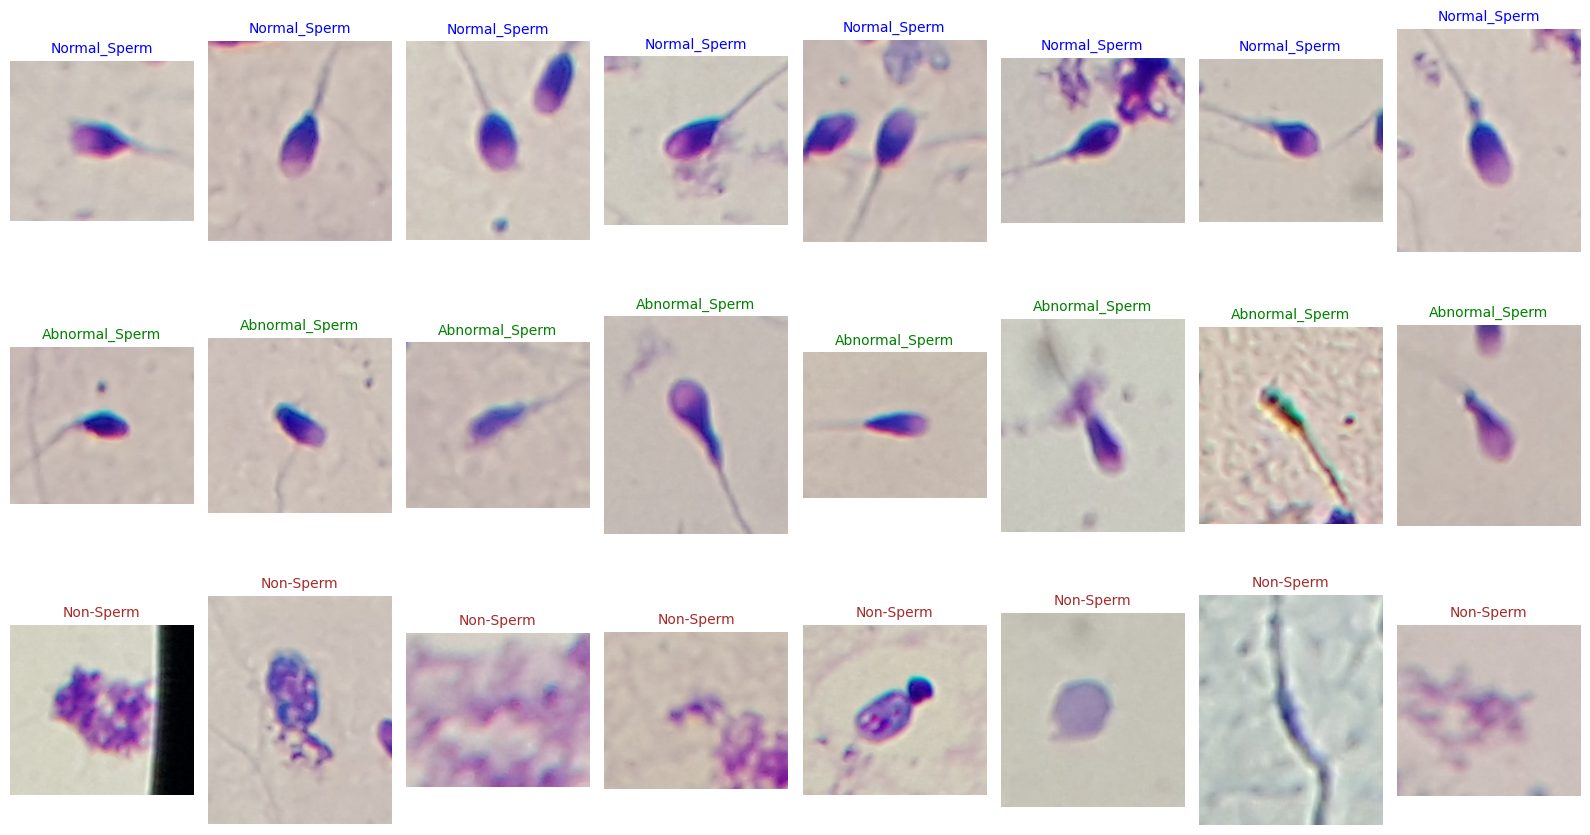

In [47]:
# Configuration for sample image display
dataset_path = r"C:\Users\User\Documents\GitHub\Sperm-Morphology Classification\sperm morphology dataset\SMIDS"
samples_per_class = 8   # Number of sample images to display per class
classes = ['Normal_Sperm', 'Abnormal_Sperm', 'Non-Sperm']

# Define colors for each class title
class_colors = {
    'Normal_Sperm': 'blue',
    'Abnormal_Sperm': 'green',
    'Non-Sperm': 'brown'
}

# Setup the plot grid (rows = classes, cols = samples per class)
fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(samples_per_class * 2, len(classes) * 3))
axes = axes.flatten()

for i, label in enumerate(classes):
    # Filter data for the current class
    class_data = df[df['label'] == label]
    
    # Randomly sample images
    n_samples = min(len(class_data), samples_per_class)
    sample_images = random.sample(list(class_data['file_path']), n_samples)
    
    for j, img_path in enumerate(sample_images):
        ax_idx = i * samples_per_class + j
        
        # Handle path construction
        if not os.path.isabs(img_path):
            full_path = os.path.join(dataset_path, label, img_path)
        else:
            full_path = img_path

        try:
            # Load and display image
            img = mpimg.imread(full_path)
            axes[ax_idx].imshow(img)
            axes[ax_idx].axis('off')
            
            # Set title with class-specific color
            color = class_colors.get(label, 'black')
            axes[ax_idx].set_title(label, color=color, fontsize=10)
        except FileNotFoundError:
            axes[ax_idx].text(0.5, 0.5, "Image Not Found", ha='center')
            axes[ax_idx].axis('off')

# Hide any unused subplots
total_plots = len(classes) * samples_per_class
for k in range(len(classes) * n_samples, total_plots):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

### 3.3 Image Properties Analysis
Analyze a random sample image to understand its properties (dimensions, pixel values, statistics).

Image dimensions: 153 x 168 pixels with 3 color channels
Pixel value range: [6.0000, 228.0000]
Pixel statistics - Mean: 187.9140, Std: 26.2281


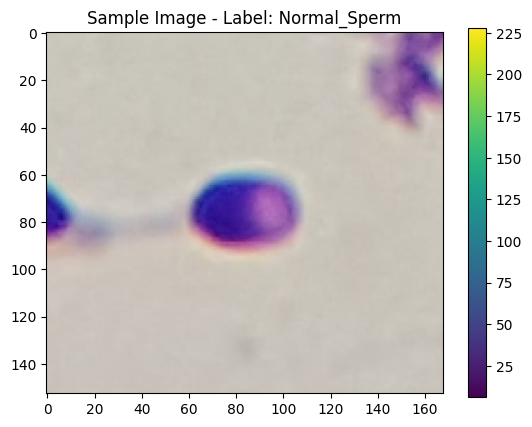

In [48]:
# Select a random sample image
random_sample_row = df.sample(n=1)

image_path = random_sample_row['file_path'].values[0]
label = random_sample_row['label'].values[0]

# Load and display the image
sample_img = plt.imread(image_path)
plt.imshow(sample_img)
plt.colorbar()
plt.title(f'Sample Image - Label: {label}')

# Print image statistics
print(f"Image dimensions: {sample_img.shape[0]} x {sample_img.shape[1]} pixels with {sample_img.shape[2]} color channels")
print(f"Pixel value range: [{sample_img.min():.4f}, {sample_img.max():.4f}]")
print(f"Pixel statistics - Mean: {sample_img.mean():.4f}, Std: {sample_img.std():.4f}")

## 4. Data Preprocessing

### 4.1 Train-Test-Validation Split
Split the dataset into training (70%), validation (21%), and test (9%) sets with stratification to maintain class balance.

In [50]:
# Split dataset: 70% train, 21% validation, 9% test
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
test_df, valid_df = train_test_split(temp_df, test_size=0.3, random_state=42, stratify=temp_df['label'])

print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)
print("Validation set shape:", valid_df.shape)

Training set shape: (2100, 2)
Testing set shape: (630, 2)
Validation set shape: (270, 2)


### 4.2 Custom Dataset Class
Define a PyTorch Dataset class to load and transform images on-the-fly.

In [51]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, c_type="RGB"):
        self.dataframe = dataframe
        self.transform = transform
        self.c_type = c_type
        self.classes = sorted(dataframe['label'].unique())  # Sort for consistent ordering
        
        # Create label to index mapping
        self.label_to_idx = {label: idx for idx, label in enumerate(self.classes)}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        label_str = self.dataframe.iloc[idx]['label']
        
        # Convert string label to integer
        label = self.label_to_idx[label_str]

        if self.c_type.upper() == "RGB":
            image = Image.open(img_path).convert('RGB')
        else:
            image = Image.open(img_path).convert('L')
            
        if self.transform:
            image = self.transform(image)

        return image, label


In [52]:
# Define transform without normalization (for calculating mean/std)
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),  # Only convert to tensor, no normalization
])

# Create dataset and dataloader
dataset = CustomImageDataset(train_df, transform=transform, c_type="GRAYSCALE")
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Initialize variables for mean and std calculation
mean = 0.0
std = 0.0
n_samples = 0

# Calculate mean and std across all training images
for images, _ in loader:
    batch_samples = images.size(0)  # Batch size
    images = images.view(batch_samples, images.size(1), -1)  # Flatten spatial dimensions
    mean += images.mean(2).sum(0)  # Mean for each channel
    std += images.std(2).sum(0)    # Standard deviation for each channel
    n_samples += batch_samples

mean /= n_samples
std /= n_samples

print(f"Calculated Mean: {mean}")
print(f"Calculated Std: {std}")

Calculated Mean: tensor([0.7302])
Calculated Std: tensor([0.1042])


### 4.3 Calculate Dataset Normalization Parameters
Calculate mean and standard deviation for normalizing the grayscale images.

### 4.4 Define Data Transformations and Create DataLoaders
Define augmentation and normalization transformations, then create PyTorch DataLoaders for training, validation, and testing.

In [54]:
# Data transformations
transform = transforms.Compose([
    # transforms.Resize((224, 224)),  
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),  # Resize short side to 224
    transforms.CenterCrop((224, 224)),  # Crop from 269x224 to 224x224
    transforms.ToTensor(),        
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    # transforms.Normalize(mean=[0.1882], std=[0.3051])  # Custom calculated values
])

# Data transformations (112x112, grayscale)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert RGB -> Grayscale
    transforms.Resize(112, interpolation=transforms.InterpolationMode.BICUBIC),  # Resize to 112x112
    transforms.CenterCrop((112, 112)),  # Center crop to 112x112
    transforms.RandomRotation(10),  # Slight rotation
    transforms.RandomHorizontalFlip(),  # Horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7303], std=[0.1039])  # Simple normalization for grayscale
])

# Create datasets
train_dataset = CustomImageDataset(train_df, transform=transform, c_type="RGB")
valid_dataset = CustomImageDataset(valid_df, transform=transform, c_type="RGB")
test_dataset = CustomImageDataset(test_df, transform=transform, c_type="RGB")  # RGB

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check dataset sizes
print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(valid_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")

classes = train_df['label'].unique()
print("Classes:", classes)


Number of batches in train loader: 66
Number of batches in validation loader: 9
Number of batches in test loader: 20
Classes: ['Non-Sperm' 'Normal_Sperm' 'Abnormal_Sperm']


In [55]:
# complete setup for preparing image data for training a deep learning model in PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split the dataset into training and testing sets (stratified by label)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

# Data transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert RGB to grayscale
    transforms.Resize(112, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop((112, 112)),
    transforms.RandomRotation(10),  # Small rotation
    transforms.RandomHorizontalFlip(),  # Horizontal flip
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Additional affine transformation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness and contrast
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7303], std=[0.1039])  # Grayscale normalization
])

# Create dataset
dataset = CustomImageDataset(train_df, transform=transform, c_type="GRAY")  # Entire dataset from train_df

# Split dataset into training and validation sets (20% validation)
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)  # Shuffle indices
train_split = int(0.8 * dataset_size)  # 80% train, 20% validation
train_indices, valid_indices = indices[:train_split], indices[train_split:]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
valid_loader = DataLoader(dataset, batch_size=32, sampler=valid_sampler)
test_loader = DataLoader(
    CustomImageDataset(test_df, transform=transform, c_type="GRAY"),
    batch_size=32,
    shuffle=False
)

# Compute class weights (only for training set)
def compute_class_weights(indices, dataset, num_classes):
    all_labels = [dataset[i][1] for i in indices]  # Labels from training indices
    class_counts = np.bincount(all_labels, minlength=num_classes)
    total_samples = len(all_labels)
    class_weights = [
        total_samples / (num_classes * count) if count > 0 else 0
        for count in class_counts
    ]
    return torch.tensor(class_weights, dtype=torch.float).to(device)

num_classes = 3
class_weights = compute_class_weights(train_indices, dataset, num_classes)
print("Class weights:", class_weights)


Training set shape: (2400, 2)
Testing set shape: (600, 2)
Class weights: tensor([0.9953, 1.0256, 0.9801], device='cuda:0')


### 4.5 Compute Class Weights
Calculate class weights to handle class imbalance during training. This helps the model pay more attention to underrepresented classes.

In [56]:
# Calculate class distribution from training data
num_classes = 3
class_counts = train_df['label'].value_counts().sort_index().values

# Compute class weights (inverse frequency)
total_samples = len(train_df)
class_weights = [total_samples / (num_classes * count) for count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use weighted CrossEntropyLoss to handle class imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights)

print("Class weights:", class_weights)

Class weights: tensor([0.9950, 1.0270, 0.9792], device='cuda:0')


## 5. Model Architecture

### 5.1 Define VGG11 Model
Create a modified VGG11 model adapted for grayscale input (1 channel) and 3-class classification.

In [57]:
def get_vgg11_model(num_classes=3, in_channels=1):
    """
    Create a modified VGG11 model for sperm morphology classification.
    
    Args:
        num_classes: Number of output classes (default: 3)
        in_channels: Number of input channels (default: 1 for grayscale)
    
    Returns:
        Modified VGG11 model
    """
    model = models.vgg11(weights=None)
    # Modify first convolutional layer to accept grayscale input
    model.features[0] = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
    # Modify final classifier layer for 3 classes
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model

# Initialize model and move to device
model = get_vgg11_model(num_classes=3, in_channels=1).to(device)
print(f"Model moved to {device}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

Model moved to cuda
Number of parameters: 128,777,475


### 5.2 Training Configuration
Set up the loss function, optimizer, learning rate scheduler, and early stopping parameters.

In [58]:
import copy
from collections import defaultdict


# Reuse loaders, device, and class_weights from above. Requires get_vgg11_model().

def evaluate_once(model, loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_labels.extend(labels.detach().cpu().numpy())
            all_preds.extend(preds.detach().cpu().numpy())
    avg_loss = running_loss / max(1, len(loader))
    acc = 100 * correct / max(1, total)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, acc, f1


# A short training function for a few epochs

def train_for_epochs(model, train_loader, valid_loader, optimizer, criterion, device, epochs=3):
    for _ in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return evaluate_once(model, valid_loader, criterion, device)


search_space = {
    'optimizer': ['Adam', 'AdamW', 'SGD'],
    'lr': [1e-4, 3e-4, 1e-3],
    'weight_decay': [0.0, 1e-4, 5e-4],
}


results = []
criterion_tune = nn.CrossEntropyLoss(weight=class_weights)


for opt_name in search_space['optimizer']:
    for lr in search_space['lr']:
        for wd in search_space['weight_decay']:
            # Fresh model for each config
            m = get_vgg11_model(num_classes=3, in_channels=1).to(device)
            if opt_name == 'Adam':
                opt = optim.Adam(m.parameters(), lr=lr, weight_decay=wd)
            elif opt_name == 'AdamW':
                opt = optim.AdamW(m.parameters(), lr=lr, weight_decay=wd)
            elif opt_name == 'SGD':
                opt = optim.SGD(m.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
            else:
                continue
            val_loss, val_acc, val_f1 = train_for_epochs(m, train_loader, valid_loader, opt, criterion_tune, device, epochs=3)
            results.append({'optimizer': opt_name, 'lr': lr, 'weight_decay': wd, 'val_loss': val_loss, 'val_acc': val_acc, 'val_f1': val_f1})
            print(f"Tuned {opt_name}, lr={lr}, wd={wd} -> acc={val_acc:.2f}%, f1={val_f1:.3f}, loss={val_loss:.3f}")


# Pick best by validation F1, break ties by accuracy
best = sorted(results, key=lambda r: (r['val_f1'], r['val_acc']), reverse=True)[0]
print("\nBest config:", best)


Tuned Adam, lr=0.0001, wd=0.0 -> acc=54.79%, f1=0.460, loss=0.849
Tuned Adam, lr=0.0001, wd=0.0001 -> acc=56.88%, f1=0.512, loss=0.785
Tuned Adam, lr=0.0001, wd=0.0005 -> acc=54.79%, f1=0.463, loss=0.880
Tuned Adam, lr=0.0003, wd=0.0 -> acc=47.71%, f1=0.388, loss=1.018
Tuned Adam, lr=0.0003, wd=0.0001 -> acc=54.17%, f1=0.524, loss=0.847
Tuned Adam, lr=0.0003, wd=0.0005 -> acc=59.38%, f1=0.605, loss=0.844
Tuned Adam, lr=0.001, wd=0.0 -> acc=34.17%, f1=0.170, loss=1.099
Tuned Adam, lr=0.001, wd=0.0001 -> acc=34.17%, f1=0.170, loss=1.099
Tuned Adam, lr=0.001, wd=0.0005 -> acc=34.17%, f1=0.170, loss=1.099
Tuned AdamW, lr=0.0001, wd=0.0 -> acc=62.29%, f1=0.633, loss=0.786
Tuned AdamW, lr=0.0001, wd=0.0001 -> acc=56.67%, f1=0.541, loss=0.843
Tuned AdamW, lr=0.0001, wd=0.0005 -> acc=58.54%, f1=0.513, loss=0.802
Tuned AdamW, lr=0.0003, wd=0.0 -> acc=41.67%, f1=0.320, loss=1.055
Tuned AdamW, lr=0.0003, wd=0.0001 -> acc=52.92%, f1=0.438, loss=0.880
Tuned AdamW, lr=0.0003, wd=0.0005 -> acc=55.21%

### 5.4 Hyperparameter Tuning 

In [ ]:
# Dynamically use best hyperparameters from the tuning sweep 
if 'best' in globals():
    model = get_vgg11_model(num_classes=3, in_channels=1).to(device)
    opt_name = best.get('optimizer', 'Adam')
    lr = float(best.get('lr', 1e-4))
    wd = float(best.get('weight_decay', 0.0))
else:
    opt_name = 'Adam'
    lr = 1e-4
    wd = 1e-4

print(f"Using optimizer: {opt_name}, lr={lr}, weight_decay={wd}")

# Loss function with class weights and label smoothing
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# Optimizer selection based on opt_name
if opt_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
elif opt_name == 'AdamW':
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
elif opt_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
else:
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

# Learning rate scheduler: Cosine annealing
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Early stopping configuration
best_valid_acc = 0.0
best_model_path = 'vgg11_model_L.pt'
patience = 50  # Stop training if no improvement for 50 epochs
early_stop_counter = 0

# Lists to track training progress
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

# Training hyperparameters
num_epochs = 100

# Training loop
for epoch in range(num_epochs):
    # ========== Training Phase ==========
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_labels = []
    all_preds = []

    train_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, (images, labels) in train_bar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Track metrics
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (preds == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        # Update progress bar
        train_loss_avg = running_loss / (i + 1)
        train_accuracy = 100 * correct_train / total_train
        train_bar.set_postfix({'loss': f'{train_loss_avg:.3f}', 'acc': f'{train_accuracy:.2f}%'})

    # Calculate training metrics
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    train_precision = precision_score(all_labels, all_preds, average='macro')
    train_recall = recall_score(all_labels, all_preds, average='macro')
    train_loss_avg = running_loss / len(train_loader)
    train_losses.append(train_loss_avg)
    train_accs.append(train_accuracy)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss_avg:.3f}, Train Acc: {train_accuracy:.2f}%, '
          f'Train F1: {train_f1:.3f}, Train Precision: {train_precision:.3f}, Train Recall: {train_recall:.3f}')

    # ========== Validation Phase ==========
    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        valid_bar = tqdm(valid_loader, total=len(valid_loader), desc="Validation")
        for images, labels in valid_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Track metrics
            valid_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (preds == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Update progress bar
            valid_loss_avg = valid_loss / len(valid_loader)
            valid_accuracy = 100 * correct_valid / total_valid
            valid_bar.set_postfix({'loss': f'{valid_loss_avg:.3f}', 'acc': f'{valid_accuracy:.2f}%'})

    # Calculate validation metrics
    valid_f1 = f1_score(all_labels, all_preds, average='macro')
    valid_precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
    valid_recall = recall_score(all_labels, all_preds, average='macro', zero_division=1)
    valid_loss_avg = valid_loss / len(valid_loader)
    valid_losses.append(valid_loss_avg)
    valid_accs.append(valid_accuracy)

    print(f'Epoch {epoch + 1}, Valid Loss: {valid_loss_avg:.3f}, Valid Acc: {valid_accuracy:.2f}%, '
          f'Valid F1: {valid_f1:.3f}, Valid Precision: {valid_precision:.3f}, Valid Recall: {valid_recall:.3f}')
    print("Validation Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

    # Save best model
    if valid_accuracy > best_valid_acc:
        best_valid_acc = valid_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved: Valid Accuracy = {best_valid_acc:.2f}%")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{patience}")

    # Update learning rate
    scheduler.step()
    print(f"Current learning rate: {scheduler.get_last_lr()[0]:.6f}")

    # Check early stopping condition
    if early_stop_counter >= patience:
        print(f"Early stopping triggered! No improvement for {patience} epochs.")
        break

print('Training completed!')

Using optimizer: AdamW, lr=0.0001, weight_decay=0.0


Epoch 1/100: 100%|██████████| 60/60 [01:06<00:00,  1.11s/it, loss=1.142, acc=33.44%]


Epoch 1, Train Loss: 1.142, Train Acc: 33.44%, Train F1: 0.313, Train Precision: 0.330, Train Recall: 0.333


Validation: 100%|██████████| 15/15 [00:15<00:00,  1.06s/it, loss=1.093, acc=44.17%]


Epoch 1, Valid Loss: 1.093, Valid Acc: 44.17%, Valid F1: 0.414, Valid Precision: 0.452, Valid Recall: 0.440
Validation Confusion Matrix:
 [[ 27  36  98]
 [ 13  70  72]
 [ 26  23 115]]
Best model saved: Valid Accuracy = 44.17%
Current learning rate: 0.000100


Epoch 2/100: 100%|██████████| 60/60 [00:15<00:00,  3.82it/s, loss=1.053, acc=43.96%]


Epoch 2, Train Loss: 1.053, Train Acc: 43.96%, Train F1: 0.435, Train Precision: 0.439, Train Recall: 0.441


Validation: 100%|██████████| 15/15 [00:02<00:00,  6.86it/s, loss=0.971, acc=53.33%]


Epoch 2, Valid Loss: 0.971, Valid Acc: 53.33%, Valid F1: 0.527, Valid Precision: 0.537, Valid Recall: 0.536
Validation Confusion Matrix:
 [[ 58  23  80]
 [ 16 113  26]
 [ 32  47  85]]
Best model saved: Valid Accuracy = 53.33%
Current learning rate: 0.000100


Epoch 3/100: 100%|██████████| 60/60 [00:15<00:00,  3.77it/s, loss=0.908, acc=56.15%]


Epoch 3, Train Loss: 0.908, Train Acc: 56.15%, Train F1: 0.565, Train Precision: 0.565, Train Recall: 0.564


Validation: 100%|██████████| 15/15 [00:01<00:00,  7.68it/s, loss=0.864, acc=57.29%]


Epoch 3, Valid Loss: 0.864, Valid Acc: 57.29%, Valid F1: 0.493, Valid Precision: 0.579, Valid Recall: 0.573
Validation Confusion Matrix:
 [[  5   9 147]
 [  6 117  32]
 [  1  10 153]]
Best model saved: Valid Accuracy = 57.29%
Current learning rate: 0.000099


Epoch 4/100: 100%|██████████| 60/60 [00:15<00:00,  3.90it/s, loss=0.862, acc=60.42%]


Epoch 4, Train Loss: 0.862, Train Acc: 60.42%, Train F1: 0.612, Train Precision: 0.620, Train Recall: 0.606


Validation: 100%|██████████| 15/15 [00:01<00:00,  7.51it/s, loss=0.852, acc=65.42%]


Epoch 4, Valid Loss: 0.852, Valid Acc: 65.42%, Valid F1: 0.659, Valid Precision: 0.669, Valid Recall: 0.655
Validation Confusion Matrix:
 [[ 89   8  64]
 [ 29 113  13]
 [ 41  11 112]]
Best model saved: Valid Accuracy = 65.42%
Current learning rate: 0.000098


Epoch 5/100: 100%|██████████| 60/60 [00:15<00:00,  3.89it/s, loss=0.827, acc=67.08%]


Epoch 5, Train Loss: 0.827, Train Acc: 67.08%, Train F1: 0.676, Train Precision: 0.685, Train Recall: 0.672


Validation: 100%|██████████| 15/15 [00:02<00:00,  6.95it/s, loss=0.960, acc=58.54%]


Epoch 5, Valid Loss: 0.960, Valid Acc: 58.54%, Valid F1: 0.567, Valid Precision: 0.684, Valid Recall: 0.581
Validation Confusion Matrix:
 [[ 58   1 102]
 [ 37  67  51]
 [  8   0 156]]
Early stopping counter: 1/50
Current learning rate: 0.000098


Epoch 6/100: 100%|██████████| 60/60 [00:15<00:00,  3.90it/s, loss=0.800, acc=71.56%]


Epoch 6, Train Loss: 0.800, Train Acc: 71.56%, Train F1: 0.720, Train Precision: 0.730, Train Recall: 0.716


Validation: 100%|██████████| 15/15 [00:01<00:00,  7.83it/s, loss=0.782, acc=73.54%]


Epoch 6, Valid Loss: 0.782, Valid Acc: 73.54%, Valid F1: 0.732, Valid Precision: 0.747, Valid Recall: 0.735
Validation Confusion Matrix:
 [[ 91  19  51]
 [ 13 122  20]
 [ 15   9 140]]
Best model saved: Valid Accuracy = 73.54%
Current learning rate: 0.000096


Epoch 7/100: 100%|██████████| 60/60 [00:15<00:00,  3.89it/s, loss=0.743, acc=74.84%]


Epoch 7, Train Loss: 0.743, Train Acc: 74.84%, Train F1: 0.751, Train Precision: 0.759, Train Recall: 0.749


Validation: 100%|██████████| 15/15 [00:02<00:00,  7.25it/s, loss=0.734, acc=74.79%]


Epoch 7, Valid Loss: 0.734, Valid Acc: 74.79%, Valid F1: 0.746, Valid Precision: 0.790, Valid Recall: 0.747
Validation Confusion Matrix:
 [[ 88   9  64]
 [  9 118  28]
 [  7   4 153]]
Best model saved: Valid Accuracy = 74.79%
Current learning rate: 0.000095


Epoch 8/100: 100%|██████████| 60/60 [00:15<00:00,  3.79it/s, loss=0.709, acc=77.40%]


Epoch 8, Train Loss: 0.709, Train Acc: 77.40%, Train F1: 0.777, Train Precision: 0.785, Train Recall: 0.774


Validation: 100%|██████████| 15/15 [00:02<00:00,  6.99it/s, loss=0.679, acc=78.33%]


Epoch 8, Valid Loss: 0.679, Valid Acc: 78.33%, Valid F1: 0.785, Valid Precision: 0.791, Valid Recall: 0.784
Validation Confusion Matrix:
 [[130  10  21]
 [ 20 123  12]
 [ 34   7 123]]
Best model saved: Valid Accuracy = 78.33%
Current learning rate: 0.000094


Epoch 9/100: 100%|██████████| 60/60 [00:15<00:00,  3.90it/s, loss=0.692, acc=78.91%]


Epoch 9, Train Loss: 0.692, Train Acc: 78.91%, Train F1: 0.791, Train Precision: 0.796, Train Recall: 0.789


Validation: 100%|██████████| 15/15 [00:01<00:00,  7.62it/s, loss=0.692, acc=78.96%]


Epoch 9, Valid Loss: 0.692, Valid Acc: 78.96%, Valid F1: 0.792, Valid Precision: 0.806, Valid Recall: 0.789
Validation Confusion Matrix:
 [[129   5  27]
 [ 19 114  22]
 [ 26   2 136]]
Best model saved: Valid Accuracy = 78.96%
Current learning rate: 0.000092


Epoch 10/100: 100%|██████████| 60/60 [00:15<00:00,  3.93it/s, loss=0.677, acc=79.64%]


Epoch 10, Train Loss: 0.677, Train Acc: 79.64%, Train F1: 0.798, Train Precision: 0.804, Train Recall: 0.796


Validation: 100%|██████████| 15/15 [00:01<00:00,  8.03it/s, loss=0.661, acc=82.08%]


Epoch 10, Valid Loss: 0.661, Valid Acc: 82.08%, Valid F1: 0.822, Valid Precision: 0.827, Valid Recall: 0.820
Validation Confusion Matrix:
 [[136   5  20]
 [ 14 123  18]
 [ 22   7 135]]
Best model saved: Valid Accuracy = 82.08%
Current learning rate: 0.000090


Epoch 11/100: 100%|██████████| 60/60 [00:10<00:00,  5.90it/s, loss=0.668, acc=80.10%]


Epoch 11, Train Loss: 0.668, Train Acc: 80.10%, Train F1: 0.803, Train Precision: 0.807, Train Recall: 0.801


Validation: 100%|██████████| 15/15 [00:00<00:00, 15.01it/s, loss=0.654, acc=79.79%]


Epoch 11, Valid Loss: 0.654, Valid Acc: 79.79%, Valid F1: 0.799, Valid Precision: 0.800, Valid Recall: 0.798
Validation Confusion Matrix:
 [[124  12  25]
 [ 10 127  18]
 [ 21  11 132]]
Early stopping counter: 1/50
Current learning rate: 0.000089


Epoch 12/100: 100%|██████████| 60/60 [00:10<00:00,  5.98it/s, loss=0.643, acc=81.46%]


Epoch 12, Train Loss: 0.643, Train Acc: 81.46%, Train F1: 0.816, Train Precision: 0.820, Train Recall: 0.815


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.66it/s, loss=0.679, acc=79.58%]


Epoch 12, Valid Loss: 0.679, Valid Acc: 79.58%, Valid F1: 0.797, Valid Precision: 0.798, Valid Recall: 0.796
Validation Confusion Matrix:
 [[124  11  26]
 [ 14 126  15]
 [ 21  11 132]]
Early stopping counter: 2/50
Current learning rate: 0.000086


Epoch 13/100: 100%|██████████| 60/60 [00:09<00:00,  6.01it/s, loss=0.640, acc=82.14%]


Epoch 13, Train Loss: 0.640, Train Acc: 82.14%, Train F1: 0.822, Train Precision: 0.827, Train Recall: 0.821


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.88it/s, loss=0.654, acc=81.67%]


Epoch 13, Valid Loss: 0.654, Valid Acc: 81.67%, Valid F1: 0.817, Valid Precision: 0.817, Valid Recall: 0.817
Validation Confusion Matrix:
 [[126  16  19]
 [ 12 134   9]
 [ 17  15 132]]
Early stopping counter: 3/50
Current learning rate: 0.000084


Epoch 14/100: 100%|██████████| 60/60 [00:09<00:00,  6.08it/s, loss=0.620, acc=83.44%]


Epoch 14, Train Loss: 0.620, Train Acc: 83.44%, Train F1: 0.836, Train Precision: 0.838, Train Recall: 0.835


Validation: 100%|██████████| 15/15 [00:00<00:00, 15.22it/s, loss=0.643, acc=82.08%]


Epoch 14, Valid Loss: 0.643, Valid Acc: 82.08%, Valid F1: 0.821, Valid Precision: 0.836, Valid Recall: 0.820
Validation Confusion Matrix:
 [[119   9  33]
 [ 10 123  22]
 [  9   3 152]]
Early stopping counter: 4/50
Current learning rate: 0.000082


Epoch 15/100: 100%|██████████| 60/60 [00:09<00:00,  6.11it/s, loss=0.625, acc=82.29%]


Epoch 15, Train Loss: 0.625, Train Acc: 82.29%, Train F1: 0.824, Train Precision: 0.827, Train Recall: 0.823


Validation: 100%|██████████| 15/15 [00:00<00:00, 15.09it/s, loss=0.686, acc=77.92%]


Epoch 15, Valid Loss: 0.686, Valid Acc: 77.92%, Valid F1: 0.778, Valid Precision: 0.812, Valid Recall: 0.777
Validation Confusion Matrix:
 [[146   2  13]
 [ 35  99  21]
 [ 33   2 129]]
Early stopping counter: 5/50
Current learning rate: 0.000079


Epoch 16/100: 100%|██████████| 60/60 [00:09<00:00,  6.10it/s, loss=0.612, acc=83.54%]


Epoch 16, Train Loss: 0.612, Train Acc: 83.54%, Train F1: 0.837, Train Precision: 0.841, Train Recall: 0.835


Validation: 100%|██████████| 15/15 [00:00<00:00, 15.18it/s, loss=0.631, acc=81.88%]


Epoch 16, Valid Loss: 0.631, Valid Acc: 81.88%, Valid F1: 0.819, Valid Precision: 0.821, Valid Recall: 0.819
Validation Confusion Matrix:
 [[121  14  26]
 [ 12 130  13]
 [ 17   5 142]]
Early stopping counter: 6/50
Current learning rate: 0.000077


Epoch 17/100: 100%|██████████| 60/60 [00:09<00:00,  6.09it/s, loss=0.599, acc=84.06%]


Epoch 17, Train Loss: 0.599, Train Acc: 84.06%, Train F1: 0.842, Train Precision: 0.844, Train Recall: 0.841


Validation: 100%|██████████| 15/15 [00:00<00:00, 15.18it/s, loss=0.614, acc=82.71%]


Epoch 17, Valid Loss: 0.614, Valid Acc: 82.71%, Valid F1: 0.829, Valid Precision: 0.838, Valid Recall: 0.827
Validation Confusion Matrix:
 [[128   4  29]
 [ 13 125  17]
 [ 17   3 144]]
Best model saved: Valid Accuracy = 82.71%
Current learning rate: 0.000074


Epoch 18/100: 100%|██████████| 60/60 [00:10<00:00,  5.71it/s, loss=0.571, acc=85.47%]


Epoch 18, Train Loss: 0.571, Train Acc: 85.47%, Train F1: 0.856, Train Precision: 0.858, Train Recall: 0.855


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.79it/s, loss=0.595, acc=84.58%]


Epoch 18, Valid Loss: 0.595, Valid Acc: 84.58%, Valid F1: 0.847, Valid Precision: 0.850, Valid Recall: 0.846
Validation Confusion Matrix:
 [[138   9  14]
 [ 12 133  10]
 [ 25   4 135]]
Best model saved: Valid Accuracy = 84.58%
Current learning rate: 0.000071


Epoch 19/100: 100%|██████████| 60/60 [00:10<00:00,  5.98it/s, loss=0.583, acc=84.58%]


Epoch 19, Train Loss: 0.583, Train Acc: 84.58%, Train F1: 0.847, Train Precision: 0.849, Train Recall: 0.846


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.80it/s, loss=0.620, acc=82.71%]


Epoch 19, Valid Loss: 0.620, Valid Acc: 82.71%, Valid F1: 0.829, Valid Precision: 0.840, Valid Recall: 0.827
Validation Confusion Matrix:
 [[143   4  14]
 [ 17 125  13]
 [ 32   3 129]]
Early stopping counter: 1/50
Current learning rate: 0.000068


Epoch 20/100: 100%|██████████| 60/60 [00:09<00:00,  6.07it/s, loss=0.572, acc=85.21%]


Epoch 20, Train Loss: 0.572, Train Acc: 85.21%, Train F1: 0.853, Train Precision: 0.855, Train Recall: 0.852


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.53it/s, loss=0.588, acc=82.92%]


Epoch 20, Valid Loss: 0.588, Valid Acc: 82.92%, Valid F1: 0.831, Valid Precision: 0.832, Valid Recall: 0.830
Validation Confusion Matrix:
 [[133   8  20]
 [ 10 137   8]
 [ 30   6 128]]
Early stopping counter: 2/50
Current learning rate: 0.000065


Epoch 21/100: 100%|██████████| 60/60 [00:10<00:00,  5.90it/s, loss=0.568, acc=85.26%]


Epoch 21, Train Loss: 0.568, Train Acc: 85.26%, Train F1: 0.854, Train Precision: 0.855, Train Recall: 0.853


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.70it/s, loss=0.618, acc=82.71%]


Epoch 21, Valid Loss: 0.618, Valid Acc: 82.71%, Valid F1: 0.829, Valid Precision: 0.836, Valid Recall: 0.826
Validation Confusion Matrix:
 [[127   5  29]
 [ 17 125  13]
 [ 16   3 145]]
Early stopping counter: 3/50
Current learning rate: 0.000062


Epoch 22/100: 100%|██████████| 60/60 [00:09<00:00,  6.06it/s, loss=0.569, acc=85.47%]


Epoch 22, Train Loss: 0.569, Train Acc: 85.47%, Train F1: 0.856, Train Precision: 0.858, Train Recall: 0.855


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.89it/s, loss=0.587, acc=83.96%]


Epoch 22, Valid Loss: 0.587, Valid Acc: 83.96%, Valid F1: 0.841, Valid Precision: 0.842, Valid Recall: 0.840
Validation Confusion Matrix:
 [[133   8  20]
 [ 14 135   6]
 [ 22   7 135]]
Early stopping counter: 4/50
Current learning rate: 0.000059


Epoch 23/100: 100%|██████████| 60/60 [00:09<00:00,  6.01it/s, loss=0.542, acc=86.46%]


Epoch 23, Train Loss: 0.542, Train Acc: 86.46%, Train F1: 0.865, Train Precision: 0.866, Train Recall: 0.865


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.95it/s, loss=0.593, acc=84.17%]


Epoch 23, Valid Loss: 0.593, Valid Acc: 84.17%, Valid F1: 0.843, Valid Precision: 0.850, Valid Recall: 0.842
Validation Confusion Matrix:
 [[142   7  12]
 [ 16 132   7]
 [ 30   4 130]]
Early stopping counter: 5/50
Current learning rate: 0.000056


Epoch 24/100: 100%|██████████| 60/60 [00:09<00:00,  6.01it/s, loss=0.546, acc=86.30%]


Epoch 24, Train Loss: 0.546, Train Acc: 86.30%, Train F1: 0.864, Train Precision: 0.865, Train Recall: 0.863


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.85it/s, loss=0.575, acc=84.58%]


Epoch 24, Valid Loss: 0.575, Valid Acc: 84.58%, Valid F1: 0.846, Valid Precision: 0.847, Valid Recall: 0.846
Validation Confusion Matrix:
 [[127  11  23]
 [ 10 139   6]
 [ 20   4 140]]
Early stopping counter: 6/50
Current learning rate: 0.000053


Epoch 25/100: 100%|██████████| 60/60 [00:09<00:00,  6.07it/s, loss=0.540, acc=87.14%]


Epoch 25, Train Loss: 0.540, Train Acc: 87.14%, Train F1: 0.872, Train Precision: 0.873, Train Recall: 0.872


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.90it/s, loss=0.575, acc=84.79%]


Epoch 25, Valid Loss: 0.575, Valid Acc: 84.79%, Valid F1: 0.849, Valid Precision: 0.852, Valid Recall: 0.848
Validation Confusion Matrix:
 [[139   7  15]
 [ 14 131  10]
 [ 22   5 137]]
Best model saved: Valid Accuracy = 84.79%
Current learning rate: 0.000050


Epoch 26/100: 100%|██████████| 60/60 [00:09<00:00,  6.00it/s, loss=0.541, acc=86.46%]


Epoch 26, Train Loss: 0.541, Train Acc: 86.46%, Train F1: 0.866, Train Precision: 0.867, Train Recall: 0.865


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.34it/s, loss=0.595, acc=83.54%]


Epoch 26, Valid Loss: 0.595, Valid Acc: 83.54%, Valid F1: 0.833, Valid Precision: 0.837, Valid Recall: 0.836
Validation Confusion Matrix:
 [[113  20  28]
 [  9 140   6]
 [ 12   4 148]]
Early stopping counter: 1/50
Current learning rate: 0.000047


Epoch 27/100: 100%|██████████| 60/60 [00:09<00:00,  6.07it/s, loss=0.521, acc=88.07%]


Epoch 27, Train Loss: 0.521, Train Acc: 88.07%, Train F1: 0.882, Train Precision: 0.882, Train Recall: 0.881


Validation: 100%|██████████| 15/15 [00:00<00:00, 15.15it/s, loss=0.577, acc=85.42%]


Epoch 27, Valid Loss: 0.577, Valid Acc: 85.42%, Valid F1: 0.855, Valid Precision: 0.859, Valid Recall: 0.854
Validation Confusion Matrix:
 [[128   7  26]
 [ 12 134   9]
 [ 15   1 148]]
Best model saved: Valid Accuracy = 85.42%
Current learning rate: 0.000044


Epoch 28/100: 100%|██████████| 60/60 [00:09<00:00,  6.04it/s, loss=0.535, acc=86.88%]


Epoch 28, Train Loss: 0.535, Train Acc: 86.88%, Train F1: 0.870, Train Precision: 0.871, Train Recall: 0.869


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.94it/s, loss=0.561, acc=85.62%]


Epoch 28, Valid Loss: 0.561, Valid Acc: 85.62%, Valid F1: 0.857, Valid Precision: 0.857, Valid Recall: 0.856
Validation Confusion Matrix:
 [[132   9  20]
 [ 12 136   7]
 [ 13   8 143]]
Best model saved: Valid Accuracy = 85.62%
Current learning rate: 0.000041


Epoch 29/100: 100%|██████████| 60/60 [00:10<00:00,  5.98it/s, loss=0.513, acc=88.28%]


Epoch 29, Train Loss: 0.513, Train Acc: 88.28%, Train F1: 0.883, Train Precision: 0.884, Train Recall: 0.883


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.60it/s, loss=0.555, acc=85.21%]


Epoch 29, Valid Loss: 0.555, Valid Acc: 85.21%, Valid F1: 0.852, Valid Precision: 0.852, Valid Recall: 0.852
Validation Confusion Matrix:
 [[127  14  20]
 [ 10 138   7]
 [ 13   7 144]]
Early stopping counter: 1/50
Current learning rate: 0.000038


Epoch 30/100: 100%|██████████| 60/60 [00:09<00:00,  6.03it/s, loss=0.521, acc=87.19%]


Epoch 30, Train Loss: 0.521, Train Acc: 87.19%, Train F1: 0.873, Train Precision: 0.874, Train Recall: 0.872


Validation: 100%|██████████| 15/15 [00:00<00:00, 15.10it/s, loss=0.566, acc=85.42%]


Epoch 30, Valid Loss: 0.566, Valid Acc: 85.42%, Valid F1: 0.855, Valid Precision: 0.857, Valid Recall: 0.854
Validation Confusion Matrix:
 [[134   9  18]
 [ 15 134   6]
 [ 20   2 142]]
Early stopping counter: 2/50
Current learning rate: 0.000035


Epoch 31/100: 100%|██████████| 60/60 [00:09<00:00,  6.09it/s, loss=0.503, acc=88.12%]


Epoch 31, Train Loss: 0.503, Train Acc: 88.12%, Train F1: 0.882, Train Precision: 0.883, Train Recall: 0.881


Validation: 100%|██████████| 15/15 [00:00<00:00, 15.20it/s, loss=0.568, acc=84.79%]


Epoch 31, Valid Loss: 0.568, Valid Acc: 84.79%, Valid F1: 0.849, Valid Precision: 0.850, Valid Recall: 0.848
Validation Confusion Matrix:
 [[130   6  25]
 [ 10 137   8]
 [ 18   6 140]]
Early stopping counter: 3/50
Current learning rate: 0.000032


Epoch 32/100: 100%|██████████| 60/60 [00:09<00:00,  6.08it/s, loss=0.502, acc=88.18%]


Epoch 32, Train Loss: 0.502, Train Acc: 88.18%, Train F1: 0.883, Train Precision: 0.883, Train Recall: 0.882


Validation: 100%|██████████| 15/15 [00:00<00:00, 15.04it/s, loss=0.588, acc=83.54%]


Epoch 32, Valid Loss: 0.588, Valid Acc: 83.54%, Valid F1: 0.837, Valid Precision: 0.843, Valid Recall: 0.835
Validation Confusion Matrix:
 [[129   5  27]
 [ 15 129  11]
 [ 19   2 143]]
Early stopping counter: 4/50
Current learning rate: 0.000029


Epoch 33/100: 100%|██████████| 60/60 [00:10<00:00,  5.94it/s, loss=0.504, acc=88.28%]


Epoch 33, Train Loss: 0.504, Train Acc: 88.28%, Train F1: 0.884, Train Precision: 0.884, Train Recall: 0.883


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.13it/s, loss=0.568, acc=85.21%]


Epoch 33, Valid Loss: 0.568, Valid Acc: 85.21%, Valid F1: 0.854, Valid Precision: 0.860, Valid Recall: 0.852
Validation Confusion Matrix:
 [[141   3  17]
 [ 16 130   9]
 [ 23   3 138]]
Early stopping counter: 5/50
Current learning rate: 0.000026


Epoch 34/100: 100%|██████████| 60/60 [00:10<00:00,  5.96it/s, loss=0.501, acc=89.01%]


Epoch 34, Train Loss: 0.501, Train Acc: 89.01%, Train F1: 0.891, Train Precision: 0.892, Train Recall: 0.890


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.60it/s, loss=0.564, acc=86.46%]


Epoch 34, Valid Loss: 0.564, Valid Acc: 86.46%, Valid F1: 0.865, Valid Precision: 0.867, Valid Recall: 0.865
Validation Confusion Matrix:
 [[133   8  20]
 [ 12 137   6]
 [ 16   3 145]]
Best model saved: Valid Accuracy = 86.46%
Current learning rate: 0.000023


Epoch 35/100: 100%|██████████| 60/60 [00:10<00:00,  5.98it/s, loss=0.494, acc=89.22%]


Epoch 35, Train Loss: 0.494, Train Acc: 89.22%, Train F1: 0.893, Train Precision: 0.893, Train Recall: 0.893


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.67it/s, loss=0.547, acc=86.25%]


Epoch 35, Valid Loss: 0.547, Valid Acc: 86.25%, Valid F1: 0.863, Valid Precision: 0.864, Valid Recall: 0.863
Validation Confusion Matrix:
 [[135   9  17]
 [ 13 136   6]
 [ 16   5 143]]
Early stopping counter: 1/50
Current learning rate: 0.000021


Epoch 36/100: 100%|██████████| 60/60 [00:10<00:00,  5.86it/s, loss=0.492, acc=89.64%]


Epoch 36, Train Loss: 0.492, Train Acc: 89.64%, Train F1: 0.897, Train Precision: 0.898, Train Recall: 0.897


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.40it/s, loss=0.546, acc=86.67%]


Epoch 36, Valid Loss: 0.546, Valid Acc: 86.67%, Valid F1: 0.867, Valid Precision: 0.867, Valid Recall: 0.867
Validation Confusion Matrix:
 [[134  12  15]
 [ 11 139   5]
 [ 15   6 143]]
Best model saved: Valid Accuracy = 86.67%
Current learning rate: 0.000018


Epoch 37/100: 100%|██████████| 60/60 [00:10<00:00,  5.89it/s, loss=0.488, acc=89.64%]


Epoch 37, Train Loss: 0.488, Train Acc: 89.64%, Train F1: 0.897, Train Precision: 0.898, Train Recall: 0.897


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.48it/s, loss=0.555, acc=86.46%]


Epoch 37, Valid Loss: 0.555, Valid Acc: 86.46%, Valid F1: 0.866, Valid Precision: 0.867, Valid Recall: 0.865
Validation Confusion Matrix:
 [[138   8  15]
 [ 11 137   7]
 [ 20   4 140]]
Early stopping counter: 1/50
Current learning rate: 0.000016


Epoch 38/100: 100%|██████████| 60/60 [00:10<00:00,  5.92it/s, loss=0.487, acc=89.58%]


Epoch 38, Train Loss: 0.487, Train Acc: 89.58%, Train F1: 0.897, Train Precision: 0.897, Train Recall: 0.896


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.54it/s, loss=0.566, acc=85.21%]


Epoch 38, Valid Loss: 0.566, Valid Acc: 85.21%, Valid F1: 0.854, Valid Precision: 0.858, Valid Recall: 0.852
Validation Confusion Matrix:
 [[140   7  14]
 [ 17 132   6]
 [ 23   4 137]]
Early stopping counter: 2/50
Current learning rate: 0.000014


Epoch 39/100: 100%|██████████| 60/60 [00:10<00:00,  5.95it/s, loss=0.485, acc=88.96%]


Epoch 39, Train Loss: 0.485, Train Acc: 88.96%, Train F1: 0.891, Train Precision: 0.891, Train Recall: 0.890


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.80it/s, loss=0.562, acc=85.42%]


Epoch 39, Valid Loss: 0.562, Valid Acc: 85.42%, Valid F1: 0.855, Valid Precision: 0.857, Valid Recall: 0.855
Validation Confusion Matrix:
 [[137   8  16]
 [ 13 138   4]
 [ 24   5 135]]
Early stopping counter: 3/50
Current learning rate: 0.000011


Epoch 40/100: 100%|██████████| 60/60 [00:10<00:00,  5.89it/s, loss=0.479, acc=90.31%]


Epoch 40, Train Loss: 0.479, Train Acc: 90.31%, Train F1: 0.904, Train Precision: 0.905, Train Recall: 0.903


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.15it/s, loss=0.568, acc=83.75%]


Epoch 40, Valid Loss: 0.568, Valid Acc: 83.75%, Valid F1: 0.838, Valid Precision: 0.840, Valid Recall: 0.838
Validation Confusion Matrix:
 [[127  10  24]
 [ 13 135   7]
 [ 20   4 140]]
Early stopping counter: 4/50
Current learning rate: 0.000010


Epoch 41/100: 100%|██████████| 60/60 [00:10<00:00,  5.98it/s, loss=0.477, acc=89.53%]


Epoch 41, Train Loss: 0.477, Train Acc: 89.53%, Train F1: 0.896, Train Precision: 0.896, Train Recall: 0.896


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.08it/s, loss=0.554, acc=86.88%]


Epoch 41, Valid Loss: 0.554, Valid Acc: 86.88%, Valid F1: 0.870, Valid Precision: 0.872, Valid Recall: 0.869
Validation Confusion Matrix:
 [[138   6  17]
 [ 12 135   8]
 [ 17   3 144]]
Best model saved: Valid Accuracy = 86.88%
Current learning rate: 0.000008


Epoch 42/100: 100%|██████████| 60/60 [00:10<00:00,  5.93it/s, loss=0.480, acc=89.58%]


Epoch 42, Train Loss: 0.480, Train Acc: 89.58%, Train F1: 0.897, Train Precision: 0.897, Train Recall: 0.896


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.76it/s, loss=0.551, acc=87.08%]


Epoch 42, Valid Loss: 0.551, Valid Acc: 87.08%, Valid F1: 0.872, Valid Precision: 0.874, Valid Recall: 0.871
Validation Confusion Matrix:
 [[137   6  18]
 [ 13 136   6]
 [ 16   3 145]]
Best model saved: Valid Accuracy = 87.08%
Current learning rate: 0.000006


Epoch 43/100: 100%|██████████| 60/60 [00:10<00:00,  5.95it/s, loss=0.474, acc=90.36%]


Epoch 43, Train Loss: 0.474, Train Acc: 90.36%, Train F1: 0.904, Train Precision: 0.904, Train Recall: 0.904


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.63it/s, loss=0.555, acc=86.67%]


Epoch 43, Valid Loss: 0.555, Valid Acc: 86.67%, Valid F1: 0.868, Valid Precision: 0.871, Valid Recall: 0.867
Validation Confusion Matrix:
 [[140   5  16]
 [ 14 133   8]
 [ 18   3 143]]
Early stopping counter: 1/50
Current learning rate: 0.000005


Epoch 44/100: 100%|██████████| 60/60 [00:10<00:00,  5.97it/s, loss=0.479, acc=89.79%]


Epoch 44, Train Loss: 0.479, Train Acc: 89.79%, Train F1: 0.899, Train Precision: 0.899, Train Recall: 0.898


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.65it/s, loss=0.542, acc=85.83%]


Epoch 44, Valid Loss: 0.542, Valid Acc: 85.83%, Valid F1: 0.860, Valid Precision: 0.863, Valid Recall: 0.858
Validation Confusion Matrix:
 [[141   4  16]
 [ 15 133   7]
 [ 21   5 138]]
Early stopping counter: 2/50
Current learning rate: 0.000004


Epoch 45/100: 100%|██████████| 60/60 [00:10<00:00,  5.97it/s, loss=0.475, acc=90.42%]


Epoch 45, Train Loss: 0.475, Train Acc: 90.42%, Train F1: 0.905, Train Precision: 0.905, Train Recall: 0.905


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.67it/s, loss=0.541, acc=87.92%]


Epoch 45, Valid Loss: 0.541, Valid Acc: 87.92%, Valid F1: 0.880, Valid Precision: 0.883, Valid Recall: 0.879
Validation Confusion Matrix:
 [[140   4  17]
 [ 15 135   5]
 [ 14   3 147]]
Best model saved: Valid Accuracy = 87.92%
Current learning rate: 0.000002


Epoch 46/100: 100%|██████████| 60/60 [00:10<00:00,  5.93it/s, loss=0.471, acc=90.26%]


Epoch 46, Train Loss: 0.471, Train Acc: 90.26%, Train F1: 0.903, Train Precision: 0.904, Train Recall: 0.903


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.64it/s, loss=0.557, acc=87.08%]


Epoch 46, Valid Loss: 0.557, Valid Acc: 87.08%, Valid F1: 0.872, Valid Precision: 0.874, Valid Recall: 0.871
Validation Confusion Matrix:
 [[141   7  13]
 [ 12 137   6]
 [ 20   4 140]]
Early stopping counter: 1/50
Current learning rate: 0.000002


Epoch 47/100: 100%|██████████| 60/60 [00:09<00:00,  6.02it/s, loss=0.472, acc=90.36%]


Epoch 47, Train Loss: 0.472, Train Acc: 90.36%, Train F1: 0.904, Train Precision: 0.905, Train Recall: 0.904


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.03it/s, loss=0.562, acc=86.04%]


Epoch 47, Valid Loss: 0.562, Valid Acc: 86.04%, Valid F1: 0.861, Valid Precision: 0.862, Valid Recall: 0.861
Validation Confusion Matrix:
 [[135   6  20]
 [ 12 138   5]
 [ 18   6 140]]
Early stopping counter: 2/50
Current learning rate: 0.000001


Epoch 48/100: 100%|██████████| 60/60 [00:09<00:00,  6.01it/s, loss=0.471, acc=90.16%]


Epoch 48, Train Loss: 0.471, Train Acc: 90.16%, Train F1: 0.902, Train Precision: 0.903, Train Recall: 0.902


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.56it/s, loss=0.538, acc=86.88%]


Epoch 48, Valid Loss: 0.538, Valid Acc: 86.88%, Valid F1: 0.870, Valid Precision: 0.872, Valid Recall: 0.869
Validation Confusion Matrix:
 [[137   5  19]
 [ 13 139   3]
 [ 19   4 141]]
Early stopping counter: 3/50
Current learning rate: 0.000000


Epoch 49/100: 100%|██████████| 60/60 [00:10<00:00,  5.99it/s, loss=0.467, acc=90.05%]


Epoch 49, Train Loss: 0.467, Train Acc: 90.05%, Train F1: 0.901, Train Precision: 0.902, Train Recall: 0.901


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.88it/s, loss=0.540, acc=86.88%]


Epoch 49, Valid Loss: 0.540, Valid Acc: 86.88%, Valid F1: 0.869, Valid Precision: 0.871, Valid Recall: 0.869
Validation Confusion Matrix:
 [[139   8  14]
 [ 15 134   6]
 [ 16   4 144]]
Early stopping counter: 4/50
Current learning rate: 0.000000


Epoch 50/100: 100%|██████████| 60/60 [00:10<00:00,  5.97it/s, loss=0.464, acc=90.99%]


Epoch 50, Train Loss: 0.464, Train Acc: 90.99%, Train F1: 0.911, Train Precision: 0.911, Train Recall: 0.910


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.33it/s, loss=0.559, acc=85.83%]


Epoch 50, Valid Loss: 0.559, Valid Acc: 85.83%, Valid F1: 0.860, Valid Precision: 0.862, Valid Recall: 0.859
Validation Confusion Matrix:
 [[137   7  17]
 [ 15 136   4]
 [ 21   4 139]]
Early stopping counter: 5/50
Current learning rate: 0.000000


Epoch 51/100: 100%|██████████| 60/60 [00:10<00:00,  5.97it/s, loss=0.473, acc=90.68%]


Epoch 51, Train Loss: 0.473, Train Acc: 90.68%, Train F1: 0.908, Train Precision: 0.908, Train Recall: 0.907


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.61it/s, loss=0.536, acc=86.88%]


Epoch 51, Valid Loss: 0.536, Valid Acc: 86.88%, Valid F1: 0.870, Valid Precision: 0.872, Valid Recall: 0.869
Validation Confusion Matrix:
 [[140   6  15]
 [ 11 139   5]
 [ 22   4 138]]
Early stopping counter: 6/50
Current learning rate: 0.000000


Epoch 52/100: 100%|██████████| 60/60 [00:10<00:00,  6.00it/s, loss=0.470, acc=90.62%]


Epoch 52, Train Loss: 0.470, Train Acc: 90.62%, Train F1: 0.907, Train Precision: 0.908, Train Recall: 0.907


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.59it/s, loss=0.536, acc=87.29%]


Epoch 52, Valid Loss: 0.536, Valid Acc: 87.29%, Valid F1: 0.874, Valid Precision: 0.875, Valid Recall: 0.873
Validation Confusion Matrix:
 [[138   6  17]
 [ 11 138   6]
 [ 17   4 143]]
Early stopping counter: 7/50
Current learning rate: 0.000000


Epoch 53/100: 100%|██████████| 60/60 [00:10<00:00,  5.95it/s, loss=0.466, acc=90.26%]


Epoch 53, Train Loss: 0.466, Train Acc: 90.26%, Train F1: 0.904, Train Precision: 0.904, Train Recall: 0.903


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.21it/s, loss=0.570, acc=85.21%]


Epoch 53, Valid Loss: 0.570, Valid Acc: 85.21%, Valid F1: 0.853, Valid Precision: 0.855, Valid Recall: 0.852
Validation Confusion Matrix:
 [[136  10  15]
 [ 14 135   6]
 [ 22   4 138]]
Early stopping counter: 8/50
Current learning rate: 0.000001


Epoch 54/100: 100%|██████████| 60/60 [00:10<00:00,  5.97it/s, loss=0.468, acc=90.42%]


Epoch 54, Train Loss: 0.468, Train Acc: 90.42%, Train F1: 0.905, Train Precision: 0.905, Train Recall: 0.904


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.34it/s, loss=0.536, acc=86.46%]


Epoch 54, Valid Loss: 0.536, Valid Acc: 86.46%, Valid F1: 0.866, Valid Precision: 0.867, Valid Recall: 0.865
Validation Confusion Matrix:
 [[137   7  17]
 [ 14 136   5]
 [ 18   4 142]]
Early stopping counter: 9/50
Current learning rate: 0.000002


Epoch 55/100: 100%|██████████| 60/60 [00:10<00:00,  5.89it/s, loss=0.464, acc=90.78%]


Epoch 55, Train Loss: 0.464, Train Acc: 90.78%, Train F1: 0.908, Train Precision: 0.909, Train Recall: 0.908


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.17it/s, loss=0.556, acc=86.25%]


Epoch 55, Valid Loss: 0.556, Valid Acc: 86.25%, Valid F1: 0.863, Valid Precision: 0.864, Valid Recall: 0.863
Validation Confusion Matrix:
 [[136   7  18]
 [ 15 136   4]
 [ 16   6 142]]
Early stopping counter: 10/50
Current learning rate: 0.000002


Epoch 56/100: 100%|██████████| 60/60 [00:10<00:00,  5.98it/s, loss=0.467, acc=90.47%]


Epoch 56, Train Loss: 0.467, Train Acc: 90.47%, Train F1: 0.905, Train Precision: 0.906, Train Recall: 0.905


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.39it/s, loss=0.548, acc=86.46%]


Epoch 56, Valid Loss: 0.548, Valid Acc: 86.46%, Valid F1: 0.866, Valid Precision: 0.867, Valid Recall: 0.865
Validation Confusion Matrix:
 [[137   9  15]
 [ 13 136   6]
 [ 20   2 142]]
Early stopping counter: 11/50
Current learning rate: 0.000004


Epoch 57/100: 100%|██████████| 60/60 [00:10<00:00,  5.95it/s, loss=0.469, acc=90.26%]


Epoch 57, Train Loss: 0.469, Train Acc: 90.26%, Train F1: 0.903, Train Precision: 0.904, Train Recall: 0.903


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.06it/s, loss=0.550, acc=86.25%]


Epoch 57, Valid Loss: 0.550, Valid Acc: 86.25%, Valid F1: 0.863, Valid Precision: 0.863, Valid Recall: 0.863
Validation Confusion Matrix:
 [[134   9  18]
 [ 11 138   6]
 [ 17   5 142]]
Early stopping counter: 12/50
Current learning rate: 0.000005


Epoch 58/100: 100%|██████████| 60/60 [00:10<00:00,  5.94it/s, loss=0.473, acc=89.95%]


Epoch 58, Train Loss: 0.473, Train Acc: 89.95%, Train F1: 0.900, Train Precision: 0.901, Train Recall: 0.900


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.49it/s, loss=0.552, acc=87.50%]


Epoch 58, Valid Loss: 0.552, Valid Acc: 87.50%, Valid F1: 0.876, Valid Precision: 0.877, Valid Recall: 0.875
Validation Confusion Matrix:
 [[138   5  18]
 [ 11 138   6]
 [ 16   4 144]]
Early stopping counter: 13/50
Current learning rate: 0.000006


Epoch 59/100: 100%|██████████| 60/60 [00:10<00:00,  5.94it/s, loss=0.469, acc=90.42%]


Epoch 59, Train Loss: 0.469, Train Acc: 90.42%, Train F1: 0.905, Train Precision: 0.905, Train Recall: 0.905


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.56it/s, loss=0.553, acc=86.88%]


Epoch 59, Valid Loss: 0.553, Valid Acc: 86.88%, Valid F1: 0.870, Valid Precision: 0.873, Valid Recall: 0.869
Validation Confusion Matrix:
 [[141   6  14]
 [ 15 135   5]
 [ 20   3 141]]
Early stopping counter: 14/50
Current learning rate: 0.000008


Epoch 60/100: 100%|██████████| 60/60 [00:10<00:00,  5.97it/s, loss=0.469, acc=90.52%]


Epoch 60, Train Loss: 0.469, Train Acc: 90.52%, Train F1: 0.906, Train Precision: 0.906, Train Recall: 0.906


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.91it/s, loss=0.542, acc=86.88%]


Epoch 60, Valid Loss: 0.542, Valid Acc: 86.88%, Valid F1: 0.869, Valid Precision: 0.872, Valid Recall: 0.868
Validation Confusion Matrix:
 [[138   6  17]
 [ 14 133   8]
 [ 14   4 146]]
Early stopping counter: 15/50
Current learning rate: 0.000010


Epoch 61/100: 100%|██████████| 60/60 [00:10<00:00,  5.82it/s, loss=0.465, acc=90.94%]


Epoch 61, Train Loss: 0.465, Train Acc: 90.94%, Train F1: 0.910, Train Precision: 0.910, Train Recall: 0.910


Validation: 100%|██████████| 15/15 [00:01<00:00, 11.30it/s, loss=0.538, acc=87.50%]


Epoch 61, Valid Loss: 0.538, Valid Acc: 87.50%, Valid F1: 0.876, Valid Precision: 0.876, Valid Recall: 0.875
Validation Confusion Matrix:
 [[136   8  17]
 [ 10 141   4]
 [ 18   3 143]]
Early stopping counter: 16/50
Current learning rate: 0.000011


Epoch 62/100: 100%|██████████| 60/60 [00:10<00:00,  5.72it/s, loss=0.472, acc=90.05%]


Epoch 62, Train Loss: 0.472, Train Acc: 90.05%, Train F1: 0.901, Train Precision: 0.902, Train Recall: 0.901


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.18it/s, loss=0.546, acc=86.88%]


Epoch 62, Valid Loss: 0.546, Valid Acc: 86.88%, Valid F1: 0.869, Valid Precision: 0.869, Valid Recall: 0.869
Validation Confusion Matrix:
 [[133  14  14]
 [ 12 141   2]
 [ 14   7 143]]
Early stopping counter: 17/50
Current learning rate: 0.000014


Epoch 63/100: 100%|██████████| 60/60 [00:10<00:00,  5.83it/s, loss=0.476, acc=90.21%]


Epoch 63, Train Loss: 0.476, Train Acc: 90.21%, Train F1: 0.903, Train Precision: 0.903, Train Recall: 0.902


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.97it/s, loss=0.567, acc=86.25%]


Epoch 63, Valid Loss: 0.567, Valid Acc: 86.25%, Valid F1: 0.864, Valid Precision: 0.865, Valid Recall: 0.863
Validation Confusion Matrix:
 [[137   8  16]
 [ 11 137   7]
 [ 21   3 140]]
Early stopping counter: 18/50
Current learning rate: 0.000016


Epoch 64/100: 100%|██████████| 60/60 [00:10<00:00,  5.79it/s, loss=0.480, acc=90.05%]


Epoch 64, Train Loss: 0.480, Train Acc: 90.05%, Train F1: 0.901, Train Precision: 0.901, Train Recall: 0.901


Validation: 100%|██████████| 15/15 [00:01<00:00, 11.50it/s, loss=0.548, acc=87.08%]


Epoch 64, Valid Loss: 0.548, Valid Acc: 87.08%, Valid F1: 0.872, Valid Precision: 0.877, Valid Recall: 0.871
Validation Confusion Matrix:
 [[142   4  15]
 [ 16 134   5]
 [ 20   2 142]]
Early stopping counter: 19/50
Current learning rate: 0.000018


Epoch 65/100: 100%|██████████| 60/60 [00:10<00:00,  5.76it/s, loss=0.474, acc=90.31%]


Epoch 65, Train Loss: 0.474, Train Acc: 90.31%, Train F1: 0.904, Train Precision: 0.905, Train Recall: 0.903


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.56it/s, loss=0.565, acc=86.88%]


Epoch 65, Valid Loss: 0.565, Valid Acc: 86.88%, Valid F1: 0.870, Valid Precision: 0.872, Valid Recall: 0.869
Validation Confusion Matrix:
 [[140   8  13]
 [ 15 135   5]
 [ 19   3 142]]
Early stopping counter: 20/50
Current learning rate: 0.000021


Epoch 66/100: 100%|██████████| 60/60 [00:10<00:00,  5.71it/s, loss=0.479, acc=89.64%]


Epoch 66, Train Loss: 0.479, Train Acc: 89.64%, Train F1: 0.897, Train Precision: 0.899, Train Recall: 0.897


Validation: 100%|██████████| 15/15 [00:01<00:00, 11.77it/s, loss=0.547, acc=85.42%]


Epoch 66, Valid Loss: 0.547, Valid Acc: 85.42%, Valid F1: 0.855, Valid Precision: 0.857, Valid Recall: 0.854
Validation Confusion Matrix:
 [[134   8  19]
 [ 14 132   9]
 [ 16   4 144]]
Early stopping counter: 21/50
Current learning rate: 0.000023


Epoch 67/100: 100%|██████████| 60/60 [00:10<00:00,  5.71it/s, loss=0.474, acc=89.22%]


Epoch 67, Train Loss: 0.474, Train Acc: 89.22%, Train F1: 0.893, Train Precision: 0.894, Train Recall: 0.893


Validation: 100%|██████████| 15/15 [00:01<00:00, 11.49it/s, loss=0.550, acc=87.29%]


Epoch 67, Valid Loss: 0.550, Valid Acc: 87.29%, Valid F1: 0.874, Valid Precision: 0.875, Valid Recall: 0.874
Validation Confusion Matrix:
 [[140   8  13]
 [  9 141   5]
 [ 22   4 138]]
Early stopping counter: 22/50
Current learning rate: 0.000026


Epoch 68/100: 100%|██████████| 60/60 [00:10<00:00,  5.77it/s, loss=0.483, acc=89.38%]


Epoch 68, Train Loss: 0.483, Train Acc: 89.38%, Train F1: 0.895, Train Precision: 0.896, Train Recall: 0.894


Validation: 100%|██████████| 15/15 [00:01<00:00, 11.50it/s, loss=0.559, acc=85.42%]


Epoch 68, Valid Loss: 0.559, Valid Acc: 85.42%, Valid F1: 0.855, Valid Precision: 0.859, Valid Recall: 0.855
Validation Confusion Matrix:
 [[141  12   8]
 [ 13 138   4]
 [ 26   7 131]]
Early stopping counter: 23/50
Current learning rate: 0.000029


Epoch 69/100: 100%|██████████| 60/60 [00:10<00:00,  5.80it/s, loss=0.481, acc=89.58%]


Epoch 69, Train Loss: 0.481, Train Acc: 89.58%, Train F1: 0.896, Train Precision: 0.897, Train Recall: 0.896


Validation: 100%|██████████| 15/15 [00:01<00:00, 11.69it/s, loss=0.563, acc=87.08%]


Epoch 69, Valid Loss: 0.563, Valid Acc: 87.08%, Valid F1: 0.871, Valid Precision: 0.878, Valid Recall: 0.870
Validation Confusion Matrix:
 [[135   4  22]
 [ 16 129  10]
 [  8   2 154]]
Early stopping counter: 24/50
Current learning rate: 0.000032


Epoch 70/100: 100%|██████████| 60/60 [00:10<00:00,  5.76it/s, loss=0.480, acc=89.38%]


Epoch 70, Train Loss: 0.480, Train Acc: 89.38%, Train F1: 0.895, Train Precision: 0.896, Train Recall: 0.894


Validation: 100%|██████████| 15/15 [00:01<00:00, 11.75it/s, loss=0.551, acc=86.88%]


Epoch 70, Valid Loss: 0.551, Valid Acc: 86.88%, Valid F1: 0.870, Valid Precision: 0.870, Valid Recall: 0.869
Validation Confusion Matrix:
 [[136   6  19]
 [ 16 137   2]
 [ 14   6 144]]
Early stopping counter: 25/50
Current learning rate: 0.000035


Epoch 71/100: 100%|██████████| 60/60 [00:10<00:00,  5.68it/s, loss=0.490, acc=89.01%]


Epoch 71, Train Loss: 0.490, Train Acc: 89.01%, Train F1: 0.891, Train Precision: 0.891, Train Recall: 0.890


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.09it/s, loss=0.535, acc=87.92%]


Epoch 71, Valid Loss: 0.535, Valid Acc: 87.92%, Valid F1: 0.880, Valid Precision: 0.882, Valid Recall: 0.879
Validation Confusion Matrix:
 [[138   6  17]
 [ 13 136   6]
 [ 13   3 148]]
Early stopping counter: 26/50
Current learning rate: 0.000038


Epoch 72/100: 100%|██████████| 60/60 [00:11<00:00,  5.42it/s, loss=0.486, acc=90.05%]


Epoch 72, Train Loss: 0.486, Train Acc: 90.05%, Train F1: 0.902, Train Precision: 0.903, Train Recall: 0.901


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.48it/s, loss=0.558, acc=85.62%]


Epoch 72, Valid Loss: 0.558, Valid Acc: 85.62%, Valid F1: 0.857, Valid Precision: 0.858, Valid Recall: 0.857
Validation Confusion Matrix:
 [[131   8  22]
 [ 10 139   6]
 [ 18   5 141]]
Early stopping counter: 27/50
Current learning rate: 0.000041


Epoch 73/100: 100%|██████████| 60/60 [00:10<00:00,  5.85it/s, loss=0.505, acc=88.28%]


Epoch 73, Train Loss: 0.505, Train Acc: 88.28%, Train F1: 0.884, Train Precision: 0.884, Train Recall: 0.883


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.38it/s, loss=0.576, acc=84.58%]


Epoch 73, Valid Loss: 0.576, Valid Acc: 84.58%, Valid F1: 0.846, Valid Precision: 0.848, Valid Recall: 0.846
Validation Confusion Matrix:
 [[124  10  27]
 [ 10 138   7]
 [ 14   6 144]]
Early stopping counter: 28/50
Current learning rate: 0.000044


Epoch 74/100: 100%|██████████| 60/60 [00:10<00:00,  5.91it/s, loss=0.487, acc=88.80%]


Epoch 74, Train Loss: 0.487, Train Acc: 88.80%, Train F1: 0.889, Train Precision: 0.890, Train Recall: 0.888


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.07it/s, loss=0.554, acc=87.50%]


Epoch 74, Valid Loss: 0.554, Valid Acc: 87.50%, Valid F1: 0.876, Valid Precision: 0.880, Valid Recall: 0.875
Validation Confusion Matrix:
 [[145   4  12]
 [ 12 136   7]
 [ 21   4 139]]
Early stopping counter: 29/50
Current learning rate: 0.000047


Epoch 75/100: 100%|██████████| 60/60 [00:10<00:00,  5.91it/s, loss=0.486, acc=89.84%]


Epoch 75, Train Loss: 0.486, Train Acc: 89.84%, Train F1: 0.899, Train Precision: 0.900, Train Recall: 0.899


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.06it/s, loss=0.577, acc=85.83%]


Epoch 75, Valid Loss: 0.577, Valid Acc: 85.83%, Valid F1: 0.860, Valid Precision: 0.862, Valid Recall: 0.858
Validation Confusion Matrix:
 [[136   6  19]
 [ 14 134   7]
 [ 19   3 142]]
Early stopping counter: 30/50
Current learning rate: 0.000050


Epoch 76/100: 100%|██████████| 60/60 [00:10<00:00,  5.81it/s, loss=0.507, acc=88.39%]


Epoch 76, Train Loss: 0.507, Train Acc: 88.39%, Train F1: 0.885, Train Precision: 0.886, Train Recall: 0.884


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.69it/s, loss=0.580, acc=85.42%]


Epoch 76, Valid Loss: 0.580, Valid Acc: 85.42%, Valid F1: 0.854, Valid Precision: 0.858, Valid Recall: 0.854
Validation Confusion Matrix:
 [[129   8  24]
 [ 13 132  10]
 [ 11   4 149]]
Early stopping counter: 31/50
Current learning rate: 0.000053


Epoch 77/100: 100%|██████████| 60/60 [00:10<00:00,  5.84it/s, loss=0.485, acc=89.79%]


Epoch 77, Train Loss: 0.485, Train Acc: 89.79%, Train F1: 0.899, Train Precision: 0.899, Train Recall: 0.898


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.88it/s, loss=0.583, acc=85.21%]


Epoch 77, Valid Loss: 0.583, Valid Acc: 85.21%, Valid F1: 0.853, Valid Precision: 0.856, Valid Recall: 0.852
Validation Confusion Matrix:
 [[132   6  23]
 [ 14 133   8]
 [ 16   4 144]]
Early stopping counter: 32/50
Current learning rate: 0.000056


Epoch 78/100: 100%|██████████| 60/60 [00:10<00:00,  5.89it/s, loss=0.485, acc=90.00%]


Epoch 78, Train Loss: 0.485, Train Acc: 90.00%, Train F1: 0.901, Train Precision: 0.901, Train Recall: 0.900


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.09it/s, loss=0.551, acc=86.88%]


Epoch 78, Valid Loss: 0.551, Valid Acc: 86.88%, Valid F1: 0.869, Valid Precision: 0.869, Valid Recall: 0.869
Validation Confusion Matrix:
 [[131  11  19]
 [ 11 140   4]
 [ 13   5 146]]
Early stopping counter: 33/50
Current learning rate: 0.000059


Epoch 79/100: 100%|██████████| 60/60 [00:10<00:00,  5.90it/s, loss=0.490, acc=88.96%]


Epoch 79, Train Loss: 0.490, Train Acc: 88.96%, Train F1: 0.891, Train Precision: 0.891, Train Recall: 0.890


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.74it/s, loss=0.559, acc=85.42%]


Epoch 79, Valid Loss: 0.559, Valid Acc: 85.42%, Valid F1: 0.855, Valid Precision: 0.857, Valid Recall: 0.854
Validation Confusion Matrix:
 [[135   5  21]
 [ 11 134  10]
 [ 17   6 141]]
Early stopping counter: 34/50
Current learning rate: 0.000062


Epoch 80/100: 100%|██████████| 60/60 [00:10<00:00,  5.84it/s, loss=0.496, acc=89.43%]


Epoch 80, Train Loss: 0.496, Train Acc: 89.43%, Train F1: 0.895, Train Precision: 0.896, Train Recall: 0.895


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.15it/s, loss=0.556, acc=86.88%]


Epoch 80, Valid Loss: 0.556, Valid Acc: 86.88%, Valid F1: 0.870, Valid Precision: 0.873, Valid Recall: 0.869
Validation Confusion Matrix:
 [[139   5  17]
 [ 14 134   7]
 [ 18   2 144]]
Early stopping counter: 35/50
Current learning rate: 0.000065


Epoch 81/100: 100%|██████████| 60/60 [00:10<00:00,  5.47it/s, loss=0.496, acc=88.59%]


Epoch 81, Train Loss: 0.496, Train Acc: 88.59%, Train F1: 0.887, Train Precision: 0.887, Train Recall: 0.886


Validation: 100%|██████████| 15/15 [00:01<00:00, 10.82it/s, loss=0.569, acc=85.42%]


Epoch 81, Valid Loss: 0.569, Valid Acc: 85.42%, Valid F1: 0.855, Valid Precision: 0.857, Valid Recall: 0.854
Validation Confusion Matrix:
 [[135   8  18]
 [ 13 135   7]
 [ 20   4 140]]
Early stopping counter: 36/50
Current learning rate: 0.000068


Epoch 82/100: 100%|██████████| 60/60 [00:10<00:00,  5.76it/s, loss=0.495, acc=89.64%]


Epoch 82, Train Loss: 0.495, Train Acc: 89.64%, Train F1: 0.897, Train Precision: 0.898, Train Recall: 0.897


Validation: 100%|██████████| 15/15 [00:01<00:00, 11.88it/s, loss=0.557, acc=87.08%]


Epoch 82, Valid Loss: 0.557, Valid Acc: 87.08%, Valid F1: 0.871, Valid Precision: 0.872, Valid Recall: 0.872
Validation Confusion Matrix:
 [[136  10  15]
 [ 11 143   1]
 [ 20   5 139]]
Early stopping counter: 37/50
Current learning rate: 0.000071


Epoch 83/100: 100%|██████████| 60/60 [00:10<00:00,  5.89it/s, loss=0.491, acc=89.38%]


Epoch 83, Train Loss: 0.491, Train Acc: 89.38%, Train F1: 0.895, Train Precision: 0.896, Train Recall: 0.894


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.43it/s, loss=0.580, acc=85.00%]


Epoch 83, Valid Loss: 0.580, Valid Acc: 85.00%, Valid F1: 0.852, Valid Precision: 0.855, Valid Recall: 0.850
Validation Confusion Matrix:
 [[137   6  18]
 [ 14 132   9]
 [ 22   3 139]]
Early stopping counter: 38/50
Current learning rate: 0.000074


Epoch 84/100: 100%|██████████| 60/60 [00:10<00:00,  5.90it/s, loss=0.501, acc=88.28%]


Epoch 84, Train Loss: 0.501, Train Acc: 88.28%, Train F1: 0.884, Train Precision: 0.884, Train Recall: 0.883


Validation: 100%|██████████| 15/15 [00:01<00:00, 11.68it/s, loss=0.557, acc=85.21%]


Epoch 84, Valid Loss: 0.557, Valid Acc: 85.21%, Valid F1: 0.854, Valid Precision: 0.858, Valid Recall: 0.852
Validation Confusion Matrix:
 [[136   6  19]
 [ 18 130   7]
 [ 19   2 143]]
Early stopping counter: 39/50
Current learning rate: 0.000077


Epoch 85/100: 100%|██████████| 60/60 [00:10<00:00,  5.89it/s, loss=0.500, acc=89.38%]


Epoch 85, Train Loss: 0.500, Train Acc: 89.38%, Train F1: 0.895, Train Precision: 0.895, Train Recall: 0.894


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.17it/s, loss=0.611, acc=83.54%]


Epoch 85, Valid Loss: 0.611, Valid Acc: 83.54%, Valid F1: 0.838, Valid Precision: 0.850, Valid Recall: 0.836
Validation Confusion Matrix:
 [[144   5  12]
 [ 20 132   3]
 [ 34   5 125]]
Early stopping counter: 40/50
Current learning rate: 0.000079


Epoch 86/100: 100%|██████████| 60/60 [00:10<00:00,  5.88it/s, loss=0.484, acc=90.10%]


Epoch 86, Train Loss: 0.484, Train Acc: 90.10%, Train F1: 0.902, Train Precision: 0.902, Train Recall: 0.901


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.98it/s, loss=0.585, acc=84.58%]


Epoch 86, Valid Loss: 0.585, Valid Acc: 84.58%, Valid F1: 0.848, Valid Precision: 0.852, Valid Recall: 0.846
Validation Confusion Matrix:
 [[137  10  14]
 [ 15 136   4]
 [ 28   3 133]]
Early stopping counter: 41/50
Current learning rate: 0.000082


Epoch 87/100: 100%|██████████| 60/60 [00:10<00:00,  5.82it/s, loss=0.492, acc=88.54%]


Epoch 87, Train Loss: 0.492, Train Acc: 88.54%, Train F1: 0.886, Train Precision: 0.886, Train Recall: 0.886


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.13it/s, loss=0.566, acc=85.83%]


Epoch 87, Valid Loss: 0.566, Valid Acc: 85.83%, Valid F1: 0.857, Valid Precision: 0.858, Valid Recall: 0.859
Validation Confusion Matrix:
 [[121  21  19]
 [  9 144   2]
 [ 12   5 147]]
Early stopping counter: 42/50
Current learning rate: 0.000084


Epoch 88/100: 100%|██████████| 60/60 [00:10<00:00,  5.84it/s, loss=0.493, acc=89.32%]


Epoch 88, Train Loss: 0.493, Train Acc: 89.32%, Train F1: 0.894, Train Precision: 0.894, Train Recall: 0.894


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.13it/s, loss=0.605, acc=83.54%]


Epoch 88, Valid Loss: 0.605, Valid Acc: 83.54%, Valid F1: 0.836, Valid Precision: 0.849, Valid Recall: 0.835
Validation Confusion Matrix:
 [[122   4  35]
 [ 14 126  15]
 [  8   3 153]]
Early stopping counter: 43/50
Current learning rate: 0.000086


Epoch 89/100: 100%|██████████| 60/60 [00:10<00:00,  5.86it/s, loss=0.509, acc=88.44%]


Epoch 89, Train Loss: 0.509, Train Acc: 88.44%, Train F1: 0.885, Train Precision: 0.886, Train Recall: 0.885


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.96it/s, loss=0.574, acc=84.17%]


Epoch 89, Valid Loss: 0.574, Valid Acc: 84.17%, Valid F1: 0.843, Valid Precision: 0.848, Valid Recall: 0.842
Validation Confusion Matrix:
 [[137   6  18]
 [ 21 130   4]
 [ 22   5 137]]
Early stopping counter: 44/50
Current learning rate: 0.000089


Epoch 90/100: 100%|██████████| 60/60 [00:10<00:00,  5.91it/s, loss=0.491, acc=89.74%]


Epoch 90, Train Loss: 0.491, Train Acc: 89.74%, Train F1: 0.898, Train Precision: 0.899, Train Recall: 0.898


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.92it/s, loss=0.582, acc=84.17%]


Epoch 90, Valid Loss: 0.582, Valid Acc: 84.17%, Valid F1: 0.842, Valid Precision: 0.842, Valid Recall: 0.843
Validation Confusion Matrix:
 [[128  18  15]
 [ 10 141   4]
 [ 20   9 135]]
Early stopping counter: 45/50
Current learning rate: 0.000090


Epoch 91/100: 100%|██████████| 60/60 [00:10<00:00,  5.62it/s, loss=0.483, acc=89.69%]


Epoch 91, Train Loss: 0.483, Train Acc: 89.69%, Train F1: 0.898, Train Precision: 0.898, Train Recall: 0.897


Validation: 100%|██████████| 15/15 [00:01<00:00, 11.84it/s, loss=0.583, acc=85.62%]


Epoch 91, Valid Loss: 0.583, Valid Acc: 85.62%, Valid F1: 0.858, Valid Precision: 0.867, Valid Recall: 0.856
Validation Confusion Matrix:
 [[148   5   8]
 [ 19 129   7]
 [ 26   4 134]]
Early stopping counter: 46/50
Current learning rate: 0.000092


Epoch 92/100: 100%|██████████| 60/60 [00:10<00:00,  5.72it/s, loss=0.499, acc=88.91%]


Epoch 92, Train Loss: 0.499, Train Acc: 88.91%, Train F1: 0.890, Train Precision: 0.891, Train Recall: 0.890


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.86it/s, loss=0.557, acc=86.67%]


Epoch 92, Valid Loss: 0.557, Valid Acc: 86.67%, Valid F1: 0.868, Valid Precision: 0.872, Valid Recall: 0.867
Validation Confusion Matrix:
 [[143   4  14]
 [ 14 137   4]
 [ 23   5 136]]
Early stopping counter: 47/50
Current learning rate: 0.000094


Epoch 93/100: 100%|██████████| 60/60 [00:10<00:00,  5.83it/s, loss=0.482, acc=90.31%]


Epoch 93, Train Loss: 0.482, Train Acc: 90.31%, Train F1: 0.904, Train Precision: 0.904, Train Recall: 0.904


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.22it/s, loss=0.571, acc=85.83%]


Epoch 93, Valid Loss: 0.571, Valid Acc: 85.83%, Valid F1: 0.859, Valid Precision: 0.862, Valid Recall: 0.858
Validation Confusion Matrix:
 [[129   5  27]
 [ 13 135   7]
 [ 11   5 148]]
Early stopping counter: 48/50
Current learning rate: 0.000095


Epoch 94/100: 100%|██████████| 60/60 [00:10<00:00,  5.84it/s, loss=0.508, acc=88.23%]


Epoch 94, Train Loss: 0.508, Train Acc: 88.23%, Train F1: 0.883, Train Precision: 0.884, Train Recall: 0.882


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.06it/s, loss=0.562, acc=86.04%]


Epoch 94, Valid Loss: 0.562, Valid Acc: 86.04%, Valid F1: 0.860, Valid Precision: 0.861, Valid Recall: 0.861
Validation Confusion Matrix:
 [[125  10  26]
 [ 10 142   3]
 [ 14   4 146]]
Early stopping counter: 49/50
Current learning rate: 0.000096


Epoch 95/100: 100%|██████████| 60/60 [00:10<00:00,  5.88it/s, loss=0.483, acc=90.10%]


Epoch 95, Train Loss: 0.483, Train Acc: 90.10%, Train F1: 0.902, Train Precision: 0.902, Train Recall: 0.901


Validation: 100%|██████████| 15/15 [00:01<00:00, 11.80it/s, loss=0.570, acc=85.00%]

Epoch 95, Valid Loss: 0.570, Valid Acc: 85.00%, Valid F1: 0.852, Valid Precision: 0.856, Valid Recall: 0.850
Validation Confusion Matrix:
 [[139   6  16]
 [ 18 134   3]
 [ 24   5 135]]
Early stopping counter: 50/50
Current learning rate: 0.000098
Early stopping triggered! No improvement for 50 epochs.
Training completed!


### 5.3 Load Best Model
Load the best performing model from training for evaluation.

In [71]:
# Load the best saved model weights
best_model_path = 'vgg11_model_L.pt'
if not os.path.exists(best_model_path):
    raise FileNotFoundError(f"Model file not found: {best_model_path}")

state = torch.load(best_model_path, map_location=device)
model.load_state_dict(state)
print("Successfully loaded model from:", best_model_path)

C:\Users\User\AppData\Local\Temp\ipykernel_1664\1612118344.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(best_model_path, map_location=device)


Successfully loaded model from: vgg11_model_L.pt


## 6. Model Evaluation and Results

### 6.1 Evaluate on Validation and Test Sets
Calculate comprehensive metrics including accuracy, F1 score, and ROC AUC on both validation and test sets.

In [61]:
# Use standard CrossEntropyLoss for evaluation (no weights)
criterion = nn.CrossEntropyLoss()  

# ========== Validation Evaluation ==========
model.eval()
correct_valid = 0
total_valid = 0
valid_loss = 0.0
all_valid_labels = []
all_valid_preds = []
all_valid_probs = []

with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)  # Get class probabilities

        total_valid += labels.size(0)
        correct_valid += (preds == labels).sum().item()
        all_valid_labels.extend(labels.detach().cpu().numpy())
        all_valid_preds.extend(preds.detach().cpu().numpy())
        all_valid_probs.extend(probs.detach().cpu().numpy())

# Calculate validation metrics
valid_loss = valid_loss / len(valid_loader)
valid_accuracy = 100 * correct_valid / total_valid
valid_f1 = f1_score(all_valid_labels, all_valid_preds, average='macro')

# ROC AUC using one-vs-rest strategy
valid_auc = roc_auc_score(
    np.eye(3)[all_valid_labels],  # One-hot encoded labels
    np.array(all_valid_probs),    # Class probabilities
    multi_class='ovr'             # One-vs-rest
)

# ========== Test Evaluation ==========
correct_test = 0
total_test = 0
test_loss = 0.0
all_test_labels = []
all_test_preds = []
all_test_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)
        
        total_test += labels.size(0)
        correct_test += (preds == labels).sum().item()
        all_test_labels.extend(labels.detach().cpu().numpy())
        all_test_preds.extend(preds.detach().cpu().numpy())
        all_test_probs.extend(probs.detach().cpu().numpy())

# Calculate test metrics
test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test
test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')

# ROC AUC using one-vs-rest strategy
test_auc = roc_auc_score(
    np.eye(3)[all_test_labels],   # One-hot encoded labels
    np.array(all_test_probs),     # Class probabilities
    multi_class='ovr'
)

# ========== Display Results ==========
print("\nValidation Results:")
print(f'Validation Loss: {valid_loss:.3f}')
print(f'Validation Accuracy: {valid_accuracy:.2f}%')
print(f'Validation F1 Score: {valid_f1:.3f}')
print(f'Validation ROC AUC: {valid_auc:.3f}')
print("Validation Confusion Matrix:\n", confusion_matrix(all_valid_labels, all_valid_preds))

print("\nTest Results:")
print(f'Test Loss: {test_loss:.3f}')
print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Test F1 Score: {test_f1:.3f}')
print(f'Test ROC AUC: {test_auc:.3f}')
print("Test Confusion Matrix:\n", confusion_matrix(all_test_labels, all_test_preds))


Validation Results:
Validation Loss: 0.391
Validation Accuracy: 85.42%
Validation F1 Score: 0.855
Validation ROC AUC: 0.958
Validation Confusion Matrix:
 [[134   7  20]
 [ 14 133   8]
 [ 18   3 143]]

Test Results:
Test Loss: 0.398
Test Accuracy: 84.67%
Test F1 Score: 0.848
Test ROC AUC: 0.959
Test Confusion Matrix:
 [[164   7  30]
 [ 16 173   6]
 [ 24   9 171]]


### 6.2 Training History Visualization
Plot the training and validation loss and accuracy curves to visualize the learning process.

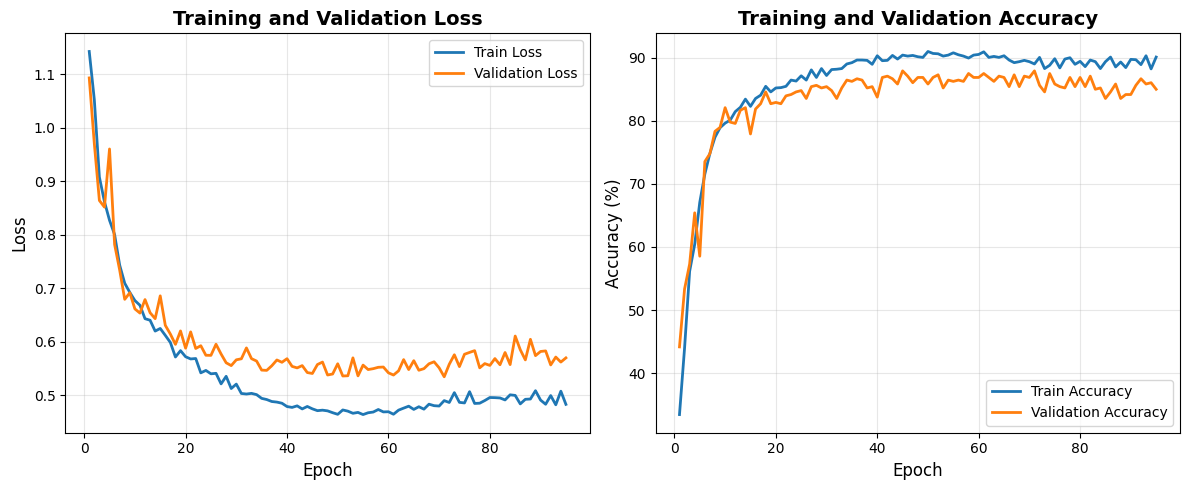

In [62]:
# Epoch range (may vary due to early stopping)
epochs_range = range(1, len(train_losses) + 1)

# Create subplots for loss and accuracy
plt.figure(figsize=(12, 5))

# ========== Loss Plot ==========
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', linewidth=2)
plt.plot(epochs_range, valid_losses, label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# ========== Accuracy Plot ==========
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label='Train Accuracy', linewidth=2)
plt.plot(epochs_range, valid_accs, label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 6.3 Classification Report
Generate detailed per-class metrics including precision, recall, and F1-score.

In [63]:
# Generate classification report for test set
print("\nClassification Report (Test Set):")
print(classification_report(all_labels, all_preds, target_names=['Normal_Sperm', 'Abnormal_Sperm', 'Non-Sperm']))


Classification Report (Test Set):
                precision    recall  f1-score   support

  Normal_Sperm       0.77      0.86      0.81       161
Abnormal_Sperm       0.92      0.86      0.89       155
     Non-Sperm       0.88      0.82      0.85       164

      accuracy                           0.85       480
     macro avg       0.86      0.85      0.85       480
  weighted avg       0.86      0.85      0.85       480



### 6.4 Confusion Matrix
Visualize the confusion matrix to understand model performance across different classes.

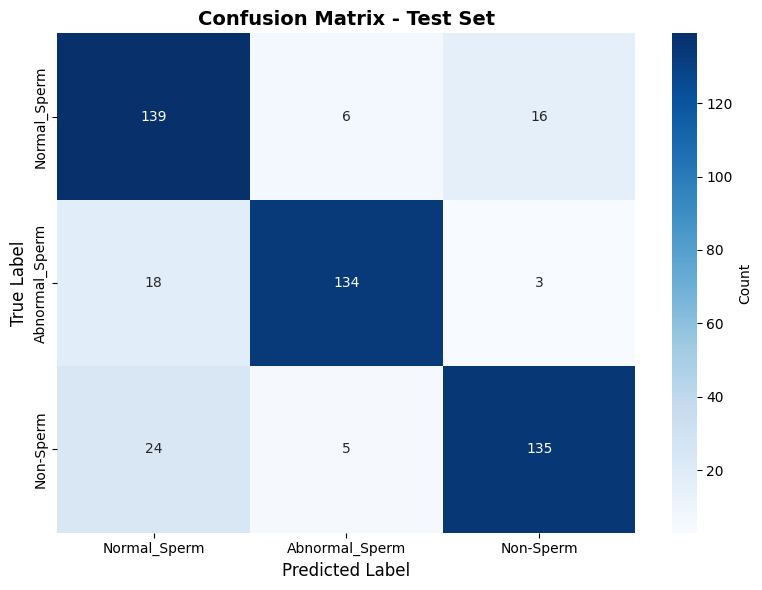

In [64]:
# Generate and visualize confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=['Normal_Sperm', 'Abnormal_Sperm', 'Non-Sperm'], 
    yticklabels=['Normal_Sperm', 'Abnormal_Sperm', 'Non-Sperm'],
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

### 6.5 ROC Curve Analysis
Plot ROC curves for each class using the One-vs-Rest strategy to evaluate classifier performance.

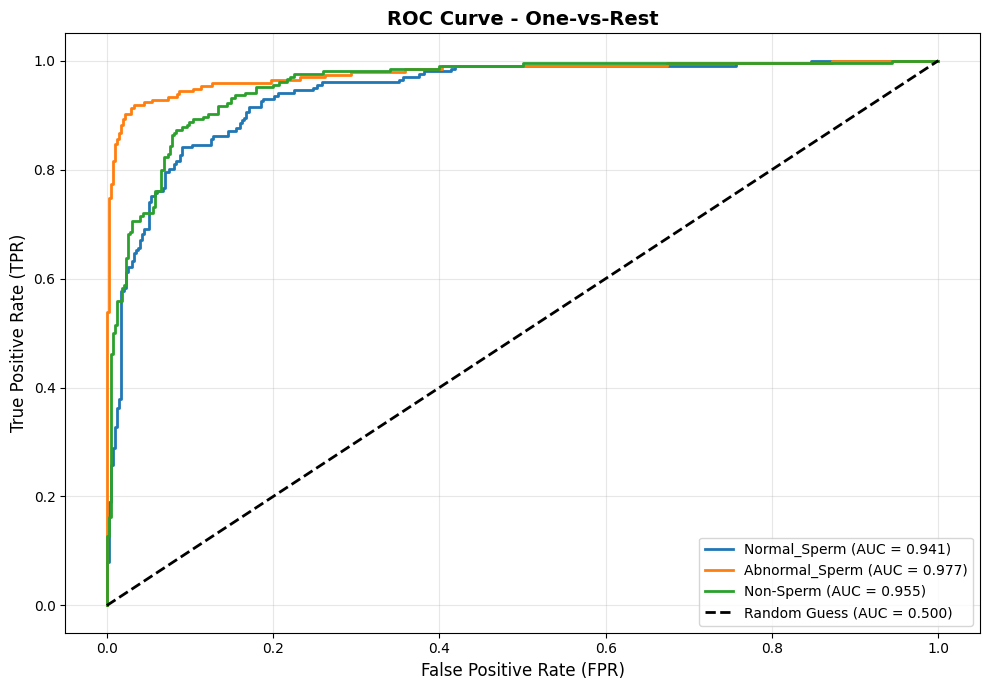


Average ROC AUC (One-vs-Rest): 0.958


In [65]:
# Prepare for ROC curve analysis
model.eval()
all_labels = []
all_probs = []

# Collect predictions and probabilities
with torch.no_grad():
    for images, labels in test_loader: 
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)  # Convert to probabilities
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Class names
class_names = ['Normal_Sperm', 'Abnormal_Sperm', 'Non-Sperm']

# Plot ROC curve for each class (One-vs-Rest)
plt.figure(figsize=(10, 7))

for i in range(3):  # Loop over 3 classes
    # Binarize labels for One-vs-Rest (current class vs all others)
    binary_labels = (all_labels == i).astype(int)
    fpr, tpr, _ = roc_curve(binary_labels, all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for this class
    plt.plot(fpr, tpr, linewidth=2, label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

# Plot random guess baseline
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Guess (AUC = 0.500)')

# Customize plot
plt.title('ROC Curve - One-vs-Rest', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Overall ROC AUC (macro average)
roc_auc_ovr = roc_auc_score(all_labels, all_probs, multi_class='ovr')
print(f"\nAverage ROC AUC (One-vs-Rest): {roc_auc_ovr:.3f}")

## 7. Model Inference on Sample Images

### 7.1 Predict on Custom Images
Test the model on specific images and visualize the predictions with confidence scores.

Class index mapping used for inference: {0: 'Abnormal_Sperm', 1: 'Non-Sperm', 2: 'Normal_Sperm'}


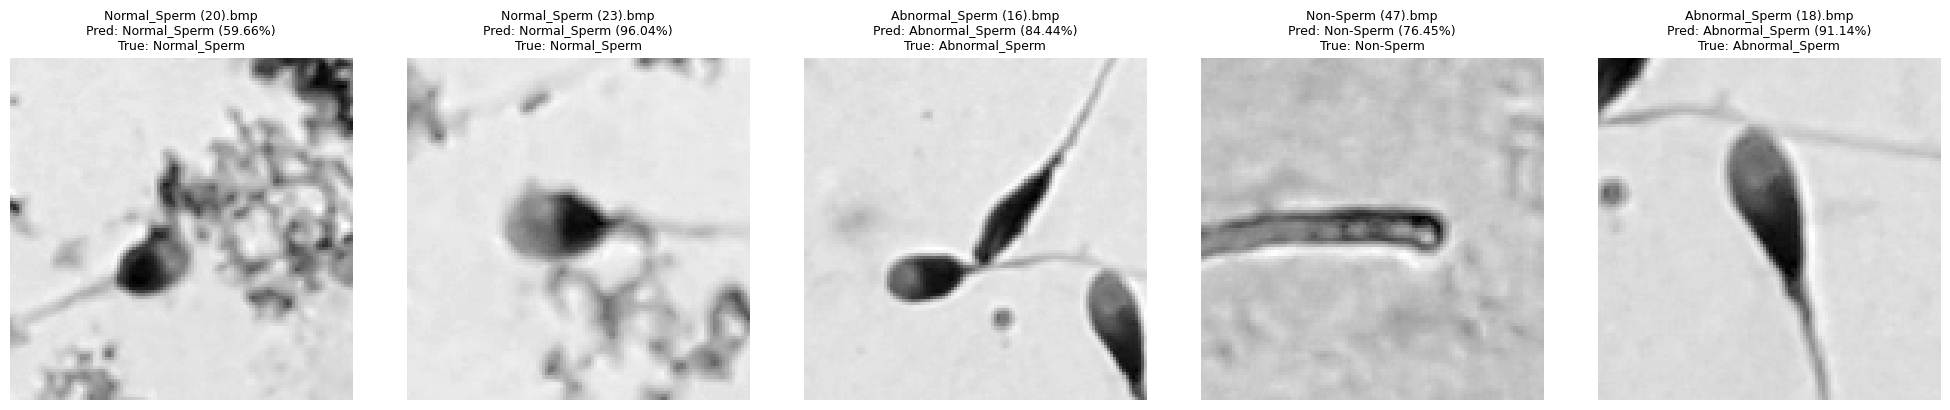


Prediction Summary:
Normal_Sperm (20).bmp -> pred=Normal_Sperm, true=Normal_Sperm
Normal_Sperm (23).bmp -> pred=Normal_Sperm, true=Normal_Sperm
Abnormal_Sperm (16).bmp -> pred=Abnormal_Sperm, true=Abnormal_Sperm
Non-Sperm (47).bmp -> pred=Non-Sperm, true=Non-Sperm
Abnormal_Sperm (18).bmp -> pred=Abnormal_Sperm, true=Abnormal_Sperm

Correct: 5/5 (100.0%)


In [70]:
# Sample image paths for inference
image_paths = [
    r"C:\\Users\\User\\Documents\\GitHub\\Sperm-Morphology Classification\\sperm morphology dataset\\SMIDS\\Normal_Sperm\\Normal_Sperm (20).bmp",
    r"C:\\Users\\User\\Documents\\GitHub\\Sperm-Morphology Classification\\sperm morphology dataset\\SMIDS\\Normal_Sperm\\Normal_Sperm (23).bmp",
    r"C:\\Users\\User\\Documents\\GitHub\\Sperm-Morphology Classification\\sperm morphology dataset\\SMIDS\\Abnormal_Sperm\\Abnormal_Sperm (16).bmp",
    r"C:\\Users\\User\\Documents\\GitHub\\Sperm-Morphology Classification\\sperm morphology dataset\\SMIDS\\Non-Sperm\\Non-Sperm (47).bmp",
    r"C:\\Users\\User\\Documents\\GitHub\\Sperm-Morphology Classification\\sperm morphology dataset\\SMIDS\\Abnormal_Sperm\\Abnormal_Sperm (18).bmp"
]

# Build class mapping consistent with the training dataset
if 'dataset' in globals() and hasattr(dataset, 'idx_to_label'):
    idx_to_label = dataset.idx_to_label
    class_names = [idx_to_label[i] for i in range(len(idx_to_label))]
    name_to_idx = {v: k for k, v in idx_to_label.items()}
else:
    # Fallback: alphabetical order
    class_names = sorted(['Normal_Sperm', 'Abnormal_Sperm', 'Non-Sperm'])
    name_to_idx = {name: i for i, name in enumerate(class_names)}

print("Class index mapping used for inference:", {i: c for i, c in enumerate(class_names)})

# Normalization used during training
mean, std = 0.7303, 0.1039

# Transform for inference (same as training evaluation)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(112, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

# Check if model and device are defined
if 'model' not in globals():
    raise RuntimeError("Model is not defined. Please run the model definition and loading cells first.")
if 'device' not in globals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Filter valid image paths
existing_paths = []
for p in image_paths:
    if os.path.exists(p):
        existing_paths.append(p)
    else:
        print(f"Warning: File not found - {p}")

if len(existing_paths) == 0:
    raise RuntimeError("No valid image paths found.")

# Predict and visualize
n = len(existing_paths)
fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
if n == 1:
    axes = [axes]

correct = 0
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for ax, p in zip(axes, existing_paths):
        # Load and preprocess image
        pil = Image.open(p).convert('L')  # Convert to grayscale
        tensor = transform(pil).unsqueeze(0).to(device)  # Add batch dimension
        
        # Get prediction
        output = model(tensor)
        probs = F.softmax(output, dim=1).cpu().numpy()[0]
        idx = int(probs.argmax())
        pred_label = class_names[idx]
        pred_prob = float(probs[idx])

        # Determine true label from folder name
        true_label = os.path.basename(os.path.dirname(p))
        yt = name_to_idx.get(true_label, -1)
        y_true.append(yt)
        y_pred.append(idx)
        if yt == idx:
            correct += 1

        # Top-3 breakdown for debugging
        topk_idx = probs.argsort()[::-1][:3]
        topk = [(class_names[i], float(probs[i])) for i in topk_idx]

        # Denormalize for display
        img_display = tensor.squeeze(0).squeeze(0).cpu() * std + mean
        img_np = img_display.numpy()

        # Display image with prediction and true label
        ax.imshow(img_np, cmap='gray')
        ax.set_title(f"{os.path.basename(p)}\nPred: {pred_label} ({pred_prob:.2%})\nTrue: {true_label}", fontsize=9)
        ax.axis('off')

plt.tight_layout()
plt.show()

# Print summary
print("\nPrediction Summary:")
for p, yt, yp in zip(existing_paths, y_true, y_pred):
    yt_name = class_names[yt] if yt != -1 else 'Unknown'
    print(f"{os.path.basename(p)} -> pred={class_names[yp]}, true={yt_name}")

print(f"\nCorrect: {correct}/{len(existing_paths)} ({100*correct/len(existing_paths):.1f}%)")